# Practical Assignment 2: Multivariate Data Analysis for Data Quality Improvement

### Objective: In this assignment, you will leverage multivariate data analysis methods to improve the quality of a dataset by understanding and handling interactions between variables. You will use the same dataset from Assignment 1, building upon the foundational improvements you made using univariate methods. This task focuses on identifying multivariate relationships, dependencies, and causality, which should further enhance the predictive quality of your model.

Performed by:
- Emil Gaibaliev (465488)
- Levon Abramian (464911)
- Sofia Romanenko (475187)

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import requests
import scipy.cluster.hierarchy as sch
import seaborn as sns
import umap

from collections import defaultdict
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from geopy import distance
from pgmpy.estimators import HillClimbSearch, BicScore
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import tqdm

In [27]:
def get_none_columns(df: pd.DataFrame) -> pd.Series:
    """
    This function takes a pandas DataFrame as input and returns a Series 
    containing the counts of missing (NaN) values in each column of the DataFrame, 
    sorted in descending order. Only columns with at least one missing value are included.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame from which to count missing values.
    
    Returns:
    pd.Series: A Series containing the count of missing values for each column
               with missing entries, sorted in descending order.
    """
    return df.isna().sum().where(lambda x : x > 0).dropna().sort_values(ascending=False)

In [28]:
def print_result(df: pd.DataFrame, lasso: bool = False, target_col: str = 'last_price') -> None:
    """
    Train and evaluate a linear regression model (optionally Lasso) using the provided DataFrame.

    This function splits the DataFrame into training and testing sets, scales the features, 
    fits the chosen regression model (Linear Regression or Lasso), and prints the evaluation metrics 
    (Mean Absolute Error, Root Mean Squared Error, and R-squared) for the predictions on the test set.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame containing features and the target variable.
    lasso : bool, optional
        If True, a Lasso regression model will be used; otherwise, a standard Linear Regression model will be used.
        Default is False.
    target_col : str, optional
        The name of the target column in the DataFrame, which is to be predicted. Default is 'last_price'.
        
    Returns:
    -------
    None
        This function does not return any values but prints the evaluation results directly.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    scaler = StandardScaler()
    X_train_st = scaler.fit_transform(X_train)
    X_test_st = scaler.transform(X_test)
    if lasso:
        model = Lasso()
    else:
        model = LinearRegression()
    model.fit(X_train_st, y_train)
    if lasso:
        print(X_train.columns[model.coef_ != 0])
    y_pred = model.predict(X_test_st)
    
    print(f'MAE:\t{mean_absolute_error(y_test, y_pred):_.2f}')
    print(f'RMSE:\t{root_mean_squared_error(y_test, y_pred):_.2f}')
    print(f'R\u00b2:\t{r2_score(y_test, y_pred):.2f}')

In [29]:
def plot_graph(df: pd.DataFrame, corr_threshold : int = 0.4) -> None:
    """
    Plots a graph visualization of the strong correlations between numeric columns in a DataFrame.

    This function computes the absolute correlations between numeric columns of the input DataFrame,
    identifies pairs of columns with correlations exceeding a specified threshold, and constructs
    a graph where nodes are the column names and edges represent the correlations.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame containing numeric columns to analyze for correlations.
    corr_threshold : float, optional
        The correlation threshold for considering strong correlations. Default is 0.4.

    Returns:
    -------
    None
        This function does not return any values but displays a graph visualization of the correlations.
    """

    # Calculate the absolute correlation matrix of the DataFrame
    strong_corrs = df_numeric.corr().abs()\
                 .stack()\
                 .reset_index()\
                 .rename({0: 'corr'}, axis=1)
    # Filter correlations that exceed the threshold and ensure unique pairs
    strong_corrs = strong_corrs.query(f"corr > {CORR_THRESHOLD}")\
                .query(f"level_0 < level_1")\
                .sort_values(by=['level_0', 'level_1'])\
                .reset_index(drop=True)\
                .round(2)

    adjacency_list = defaultdict(list)

    for _, row in strong_corrs.iterrows():
        start = row['level_0']
        end = row['level_1']
        adjacency_list[start].append(end)
        adjacency_list[end].append(start)

    G = nx.Graph()
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=16, font_color='black', edge_color='gray')
    
    plt.title("Graph Visualization from Adjacency List")
    plt.show()

In [30]:
def get_city_coordinates(cities, apikey: str = '560340bd-a288-4648-a03b-6a15a882910c'):
    """
    Retrieve geographical coordinates (latitude and longitude) for a list of city names using Yandex Geocoding API.

    Parameters:
    ----------
    cities : list
        A list of city names (strings) for which coordinates are to be retrieved.
    apikey : str
        Your Yandex Geocoding API key. Default is a placeholder; replace with your actual key.

    Returns:
    -------
    dict
        A dictionary where each city name is a key, and its corresponding value is a tuple
        containing the latitude and longitude (latitude, longitude). If the city is not found, it will not be 
        included in the dictionary.
    
    Raises:
    ------
    ValueError
        If the API response does not contain the expected data format or if the API call fails.
   
    Notes:
    -----
    - The function uses the tqdm library to display a progress bar while fetching coordinates for each city.
    - Ensure that your API key is valid and has sufficient quota to make the desired number of requests.
    """

    base_url = 'https://geocode-maps.yandex.ru/1.x/'
    coordinates = {}
    
    for city in tqdm(cities):
        if city == city:
            response = requests.get(base_url, params={
            "geocode": city,
            "apikey": apikey,
            "format": "json",
        })
            print(response.json())
            data = response.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point'].get('pos')
            coordinate = (float(data.split()[1]), float(data.split()[0]))
            coordinates[city] = coordinate
    return coordinates


def get_df_coordinate(coordinates: dict, is_save: bool = True) -> pd.DataFrame:
    """
    Convert a dictionary of city coordinates into a Pandas DataFrame.

    This function takes a dictionary where the keys are city names and the values are tuples
    of coordinates (latitude, longitude). It transforms this data into a DataFrame format, 
    adds additional columns, and optionally saves the DataFrame to a CSV file.

    Parameters:
    ----------
    coordinates : dict
        A dictionary where each key is a city name, and the value is a tuple of coordinates
        in the format (longitude, latitude). Example: {'Moscow': (37.6173, 55.7558)}.
        
    is_save : bool, optional
        A flag indicating whether to save the resulting DataFrame to a CSV file. 
        The default is True, which saves the DataFrame as 'coordinates_1.csv'.

    Returns:
    -------
    pd.DataFrame
        A Pandas DataFrame containing the city names and their corresponding coordinates.
        The DataFrame will have the following columns:
            - city: The name of the city.
            - coordinates: A tuple of (longitude, latitude).
    
    Notes:
    -----
    - The function renames the columns of the DataFrame for clarity and drops temporary
      columns used during the transformation.
    - If saving is enabled, the DataFrame is saved to 'coordinates_1.csv' in the current working directory.
    
    Examples:
    ---------
    >>> coordinates = {'Moscow': (37.6173, 55.7558), 'New York': (-74.006, 40.7128)}
    >>> df = get_df_coordinate(coordinates)
    >>> print(df)
           city         coordinates
    0  Moscow  (37.6173, 55.7558)
    1  New York  (-74.006, 40.7128)
    """
    cities_with_NaN_airport_center = pd.DataFrame(coordinates).T
    cities_with_NaN_airport_center['city'] = cities_with_NaN_airport_center.index
    cities_with_NaN_airport_center.rename({0: 'long', 1: 'lalit'}, axis=1, inplace=True)
    cities_with_NaN_airport_center['coordinates'] = cities_with_NaN_airport_center.apply(lambda x: (x.loc['long'], x.loc['lalit']), axis=1)
    cities_with_NaN_airport_center.drop(['long', 'lalit'], axis=1, inplace=True)
    cities_with_NaN_airport_center = cities_with_NaN_airport_center.reset_index(drop=True)
    if is_save:
        cities_with_NaN_airport_center.to_csv('coordicates_1.csv', index=False)
    return cities_with_NaN_airport_center

# DATASET

In [31]:
df = pd.read_csv('./real_estate_data.csv', sep='\t')
df.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

Yandex.Real Estate service data on apartment sales in St. Petersburg and neighboring towns over several years.

- airports_nearest — distance to the nearest airport in meters (m);
- balcony — number of balconies;
- ceiling_height — ceiling height (m);
- cityCenters_nearest — distance to the city center (m);
- days_exposition — number of days the ad was posted (from publication to removal);
- first_day_exposition — publication date;
- floor — floor;
- floors_total — total floors in the building;
- is_apartment — apartment (boolean type);
- kitchen_area — kitchen area in square meters (m²);
- last_price — price at the time of removal from publication;
- living_area — living area in square meters (m²);
- locality_name — name of the settlement;
- open_plan — open plan (boolean type);
- parks_around3000 — number of parks within a 3 km radius;
- parks_nearest — distance to the nearest park (m);
- ponds_around3000 — number of ponds within a radius of 3 km;
- ponds_nearest — distance to the nearest pond (m);
- rooms — number of rooms;
- studio — studio apartment (boolean type);
- total_area — area of ​​the apartment in square meters (m²);
- total_images — number of photos of the apartment in the ad.

# INITIAL MODEL

Below is a model that does not have any data processing at all. The features that need to be processed for the model to work are removed.

In [32]:
print_result(df.drop(columns=['first_day_exposition', 'locality_name']).dropna())

MAE:	4_095_149.87
RMSE:	15_679_020.24
R²:	-8.84


# BASIC EXPLORATION

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [34]:
max_name_lenght = max(map(lambda x: len(x), df.columns))
for col in df.columns:
    print(col.ljust(max_name_lenght + 1), df[col].nunique(), df[col].dtype, sep='\t')

total_images         	38	int64
last_price           	2978	float64
total_area           	2182	float64
first_day_exposition 	1491	object
rooms                	17	int64
ceiling_height       	183	float64
floors_total         	36	float64
living_area          	1782	float64
floor                	33	int64
is_apartment         	2	object
studio               	2	bool
open_plan            	2	bool
kitchen_area         	971	float64
balcony              	6	float64
locality_name        	364	object
airports_nearest     	8275	float64
cityCenters_nearest  	7642	float64
parks_around3000     	4	float64
parks_nearest        	995	float64
ponds_around3000     	4	float64
ponds_nearest        	1096	float64
days_exposition      	1141	float64


In [35]:
categorical_columns = [col for col in df.columns if df[col].dtype not in ['int64', 'float64']]
numeric_columns = list(set(df.columns) - set(categorical_columns))

In [36]:
df_categorical = df[categorical_columns]
df_numeric = df[numeric_columns]

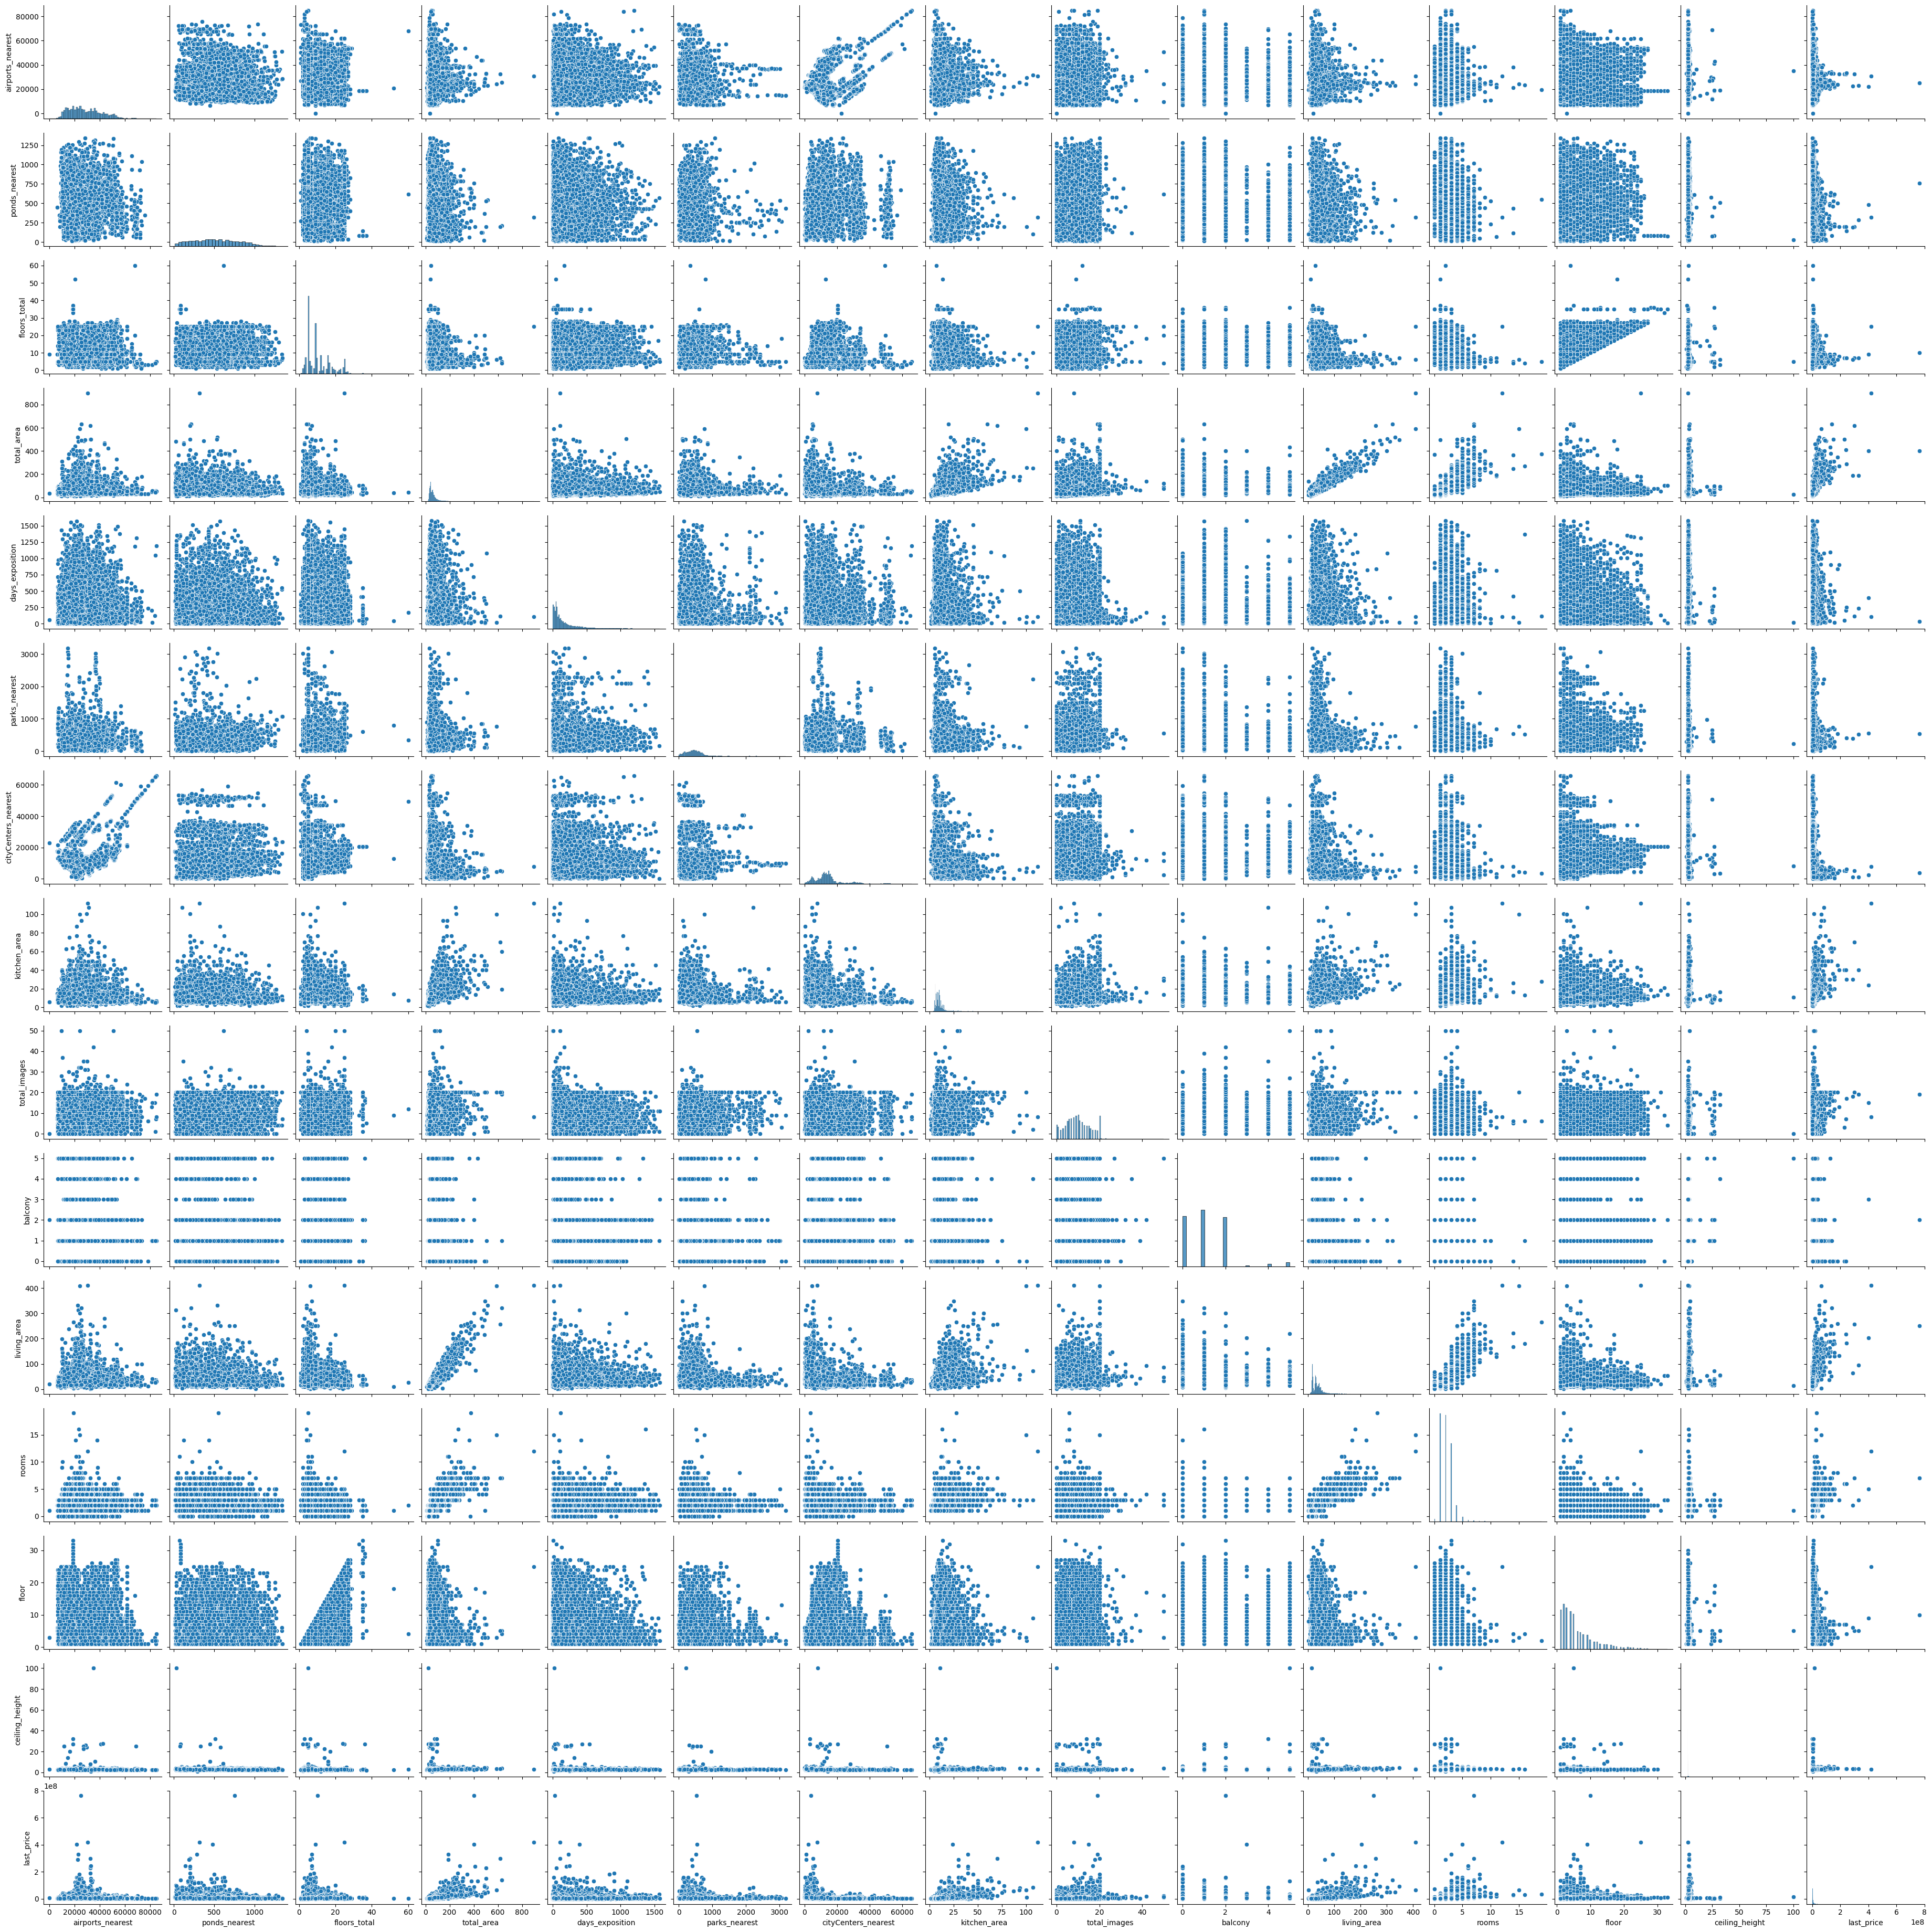

In [37]:
plt.figsize=(15, 20)
sns.pairplot(df_numeric[[col for col in df_numeric.columns if df_numeric[col].nunique() > 5]]);

Multicollinearity is a problem that arises when independent variables in linear regression are highly correlated with each other. It is undesirable for the following reasons:

1. Unstable Coefficients: Small changes in the data can lead to significant fluctuations in the coefficient estimates, making it difficult to interpret the results.

2. Interpretation Challenges: It becomes hard to ascertain the individual effect of each independent variable on the dependent variable since they are interrelated.

3. Increased Standard Errors: As a result of multicollinearity, the standard errors of the coefficients increase, which may render them statistically insignificant.

4. Reduced Predictive Power: Despite high R² values, the model may perform poorly in predicting new data.

5. Misleading Conclusions: Statistical tests may provide misleading information about the significance of variables.

### Methods to Address Multicollinearity:
- Remove or combine correlated variables.
- Use regularization methods like Ridge or Lasso.

Overall, multicollinearity complicates the analysis and interpretation of linear regression, making it important to detect and address it.

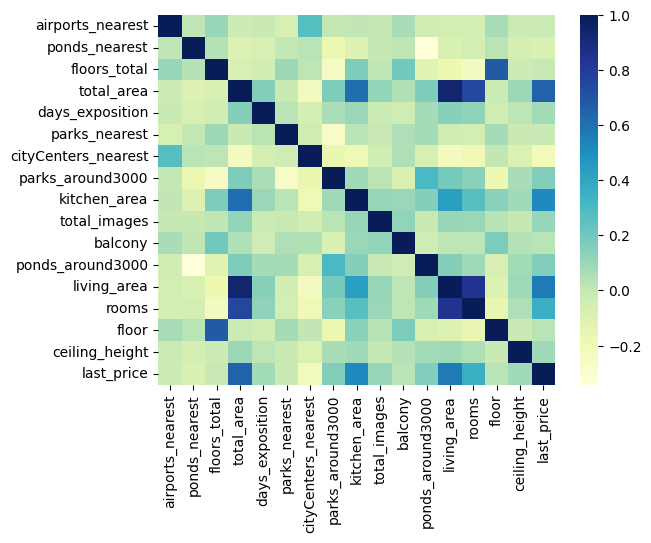

In [38]:
sns.heatmap(df_numeric.corr(),
            cmap="YlGnBu");

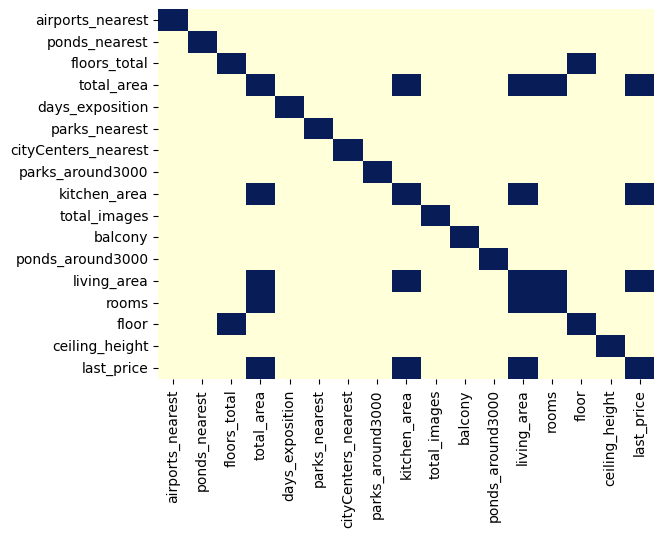

In [39]:
CORR_THRESHOLD = 0.4
sns.heatmap(df_numeric.corr().abs() > CORR_THRESHOLD,
            cmap="YlGnBu",
            cbar=False);

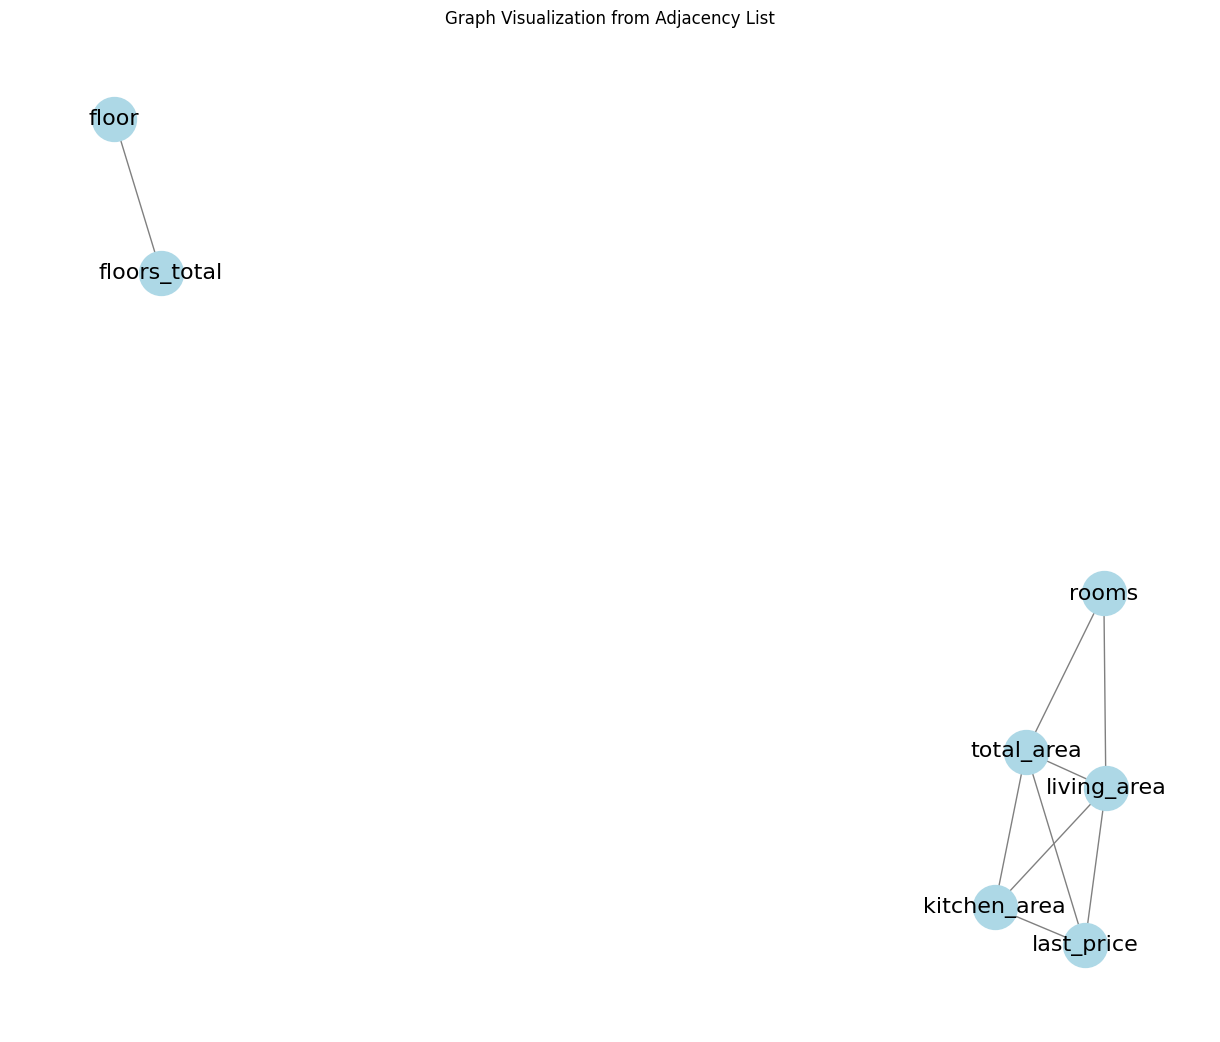

In [40]:
plot_graph(df_numeric)

In [41]:
df[['floors_total', 'floor']].isna().sum()

floors_total    86
floor            0
dtype: int64

In [42]:
df['floors_total'].corr(df['last_price'])

np.float64(-0.006983534007227371)

In [43]:
df['floor'].corr(df['last_price'])

np.float64(0.026575643284470797)

### *floors_total* will be deleted, because it has correlation with another column (*floor*) and has NaN values

In [44]:
df.drop(['floors_total'], axis=1, inplace=True)

In [45]:
print_result(df.drop(columns=['first_day_exposition', 'locality_name']).dropna())

MAE:	3_771_554.23
RMSE:	13_648_192.00
R²:	-6.46


In [46]:
corr_columns = ['kitchen_area', 'last_price', 'total_area', 'living_area', 'rooms']
df[corr_columns].isna().sum()

kitchen_area    2278
last_price         0
total_area         0
living_area     1903
rooms              0
dtype: int64

In [47]:
for col in corr_columns:
    _corr = df[col].corr(df['last_price'])
    print(f'{col} = {_corr}')
    print('--------')

kitchen_area = 0.5198690130216392
--------
last_price = 1.0
--------
total_area = 0.6536750579657242
--------
living_area = 0.5664915336952651
--------
rooms = 0.3633428499648948
--------


*kitchen_area*, *living_area* will be deleted for the same reasons, but later

In [48]:
# df.drop(['kitchen_area', 'living_area'], axis=1, inplace=True)
# print_result(df.drop(columns=['first_day_exposition', 'locality_name']).dropna())

## 0. Basic Preparation

## 0.1 Work with the object

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   living_area           21796 non-null  float64
 7   floor                 23699 non-null  int64  
 8   is_apartment          2775 non-null   object 
 9   studio                23699 non-null  bool   
 10  open_plan             23699 non-null  bool   
 11  kitchen_area          21421 non-null  float64
 12  balcony               12180 non-null  float64
 13  locality_name         23650 non-null  object 
 14  airports_nearest      18157 non-null  float64
 15  cityCenters_nearest

It is necessary to change some data types from the object to others.

Сhanging the data type first_day_exposition, and create new columns: day of the week, month, year.

In [50]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

In [51]:
df['locality_name'].value_counts().keys()

Index(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово',
       'Выборг',
       ...
       'деревня Большое Рейзино', 'деревня Малая Романовка',
       'поселок Дружноселье', 'поселок Пчевжа', 'поселок Володарское',
       'деревня Нижняя', 'коттеджный посёлок Лесное', 'деревня Тихковицы',
       'деревня Борисова Грива', 'посёлок Дзержинского'],
      dtype='object', name='locality_name', length=364)

idea with locality_name: create features is_spb

In [52]:
df['is_spb'] = df['locality_name'] == 'Санкт-Петербург'
# df.drop(['locality_name'], axis=1, inplace=True)
print_result(df.drop(columns=['locality_name', 'first_day_exposition']).dropna())

MAE:	3_472_764.12
RMSE:	11_380_645.10
R²:	-4.19


There is remain only *is_apartment* as a datatype object. There will be handled later.

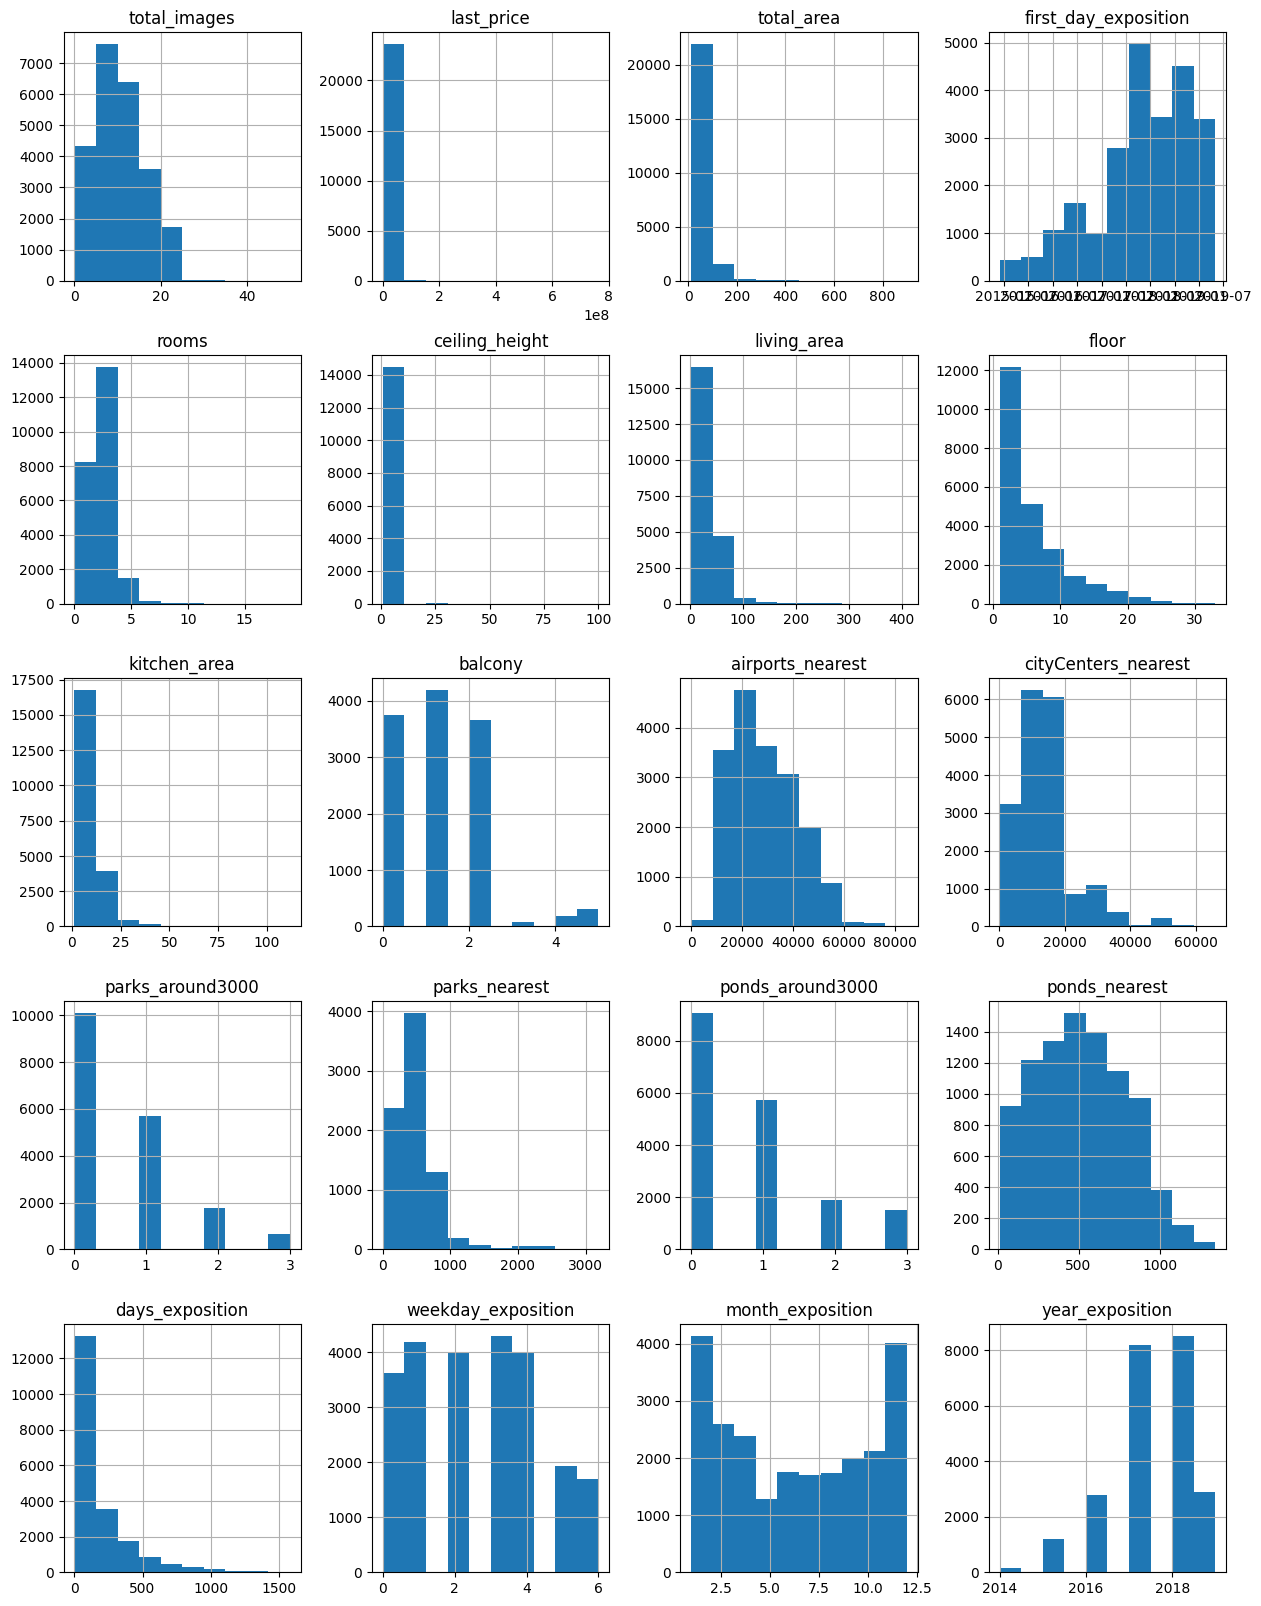

In [53]:
df.hist(figsize=(15, 20));

## 0.2 Work with NULLs

In [54]:
none_info = get_none_columns(df)
none_info

is_apartment           20924.0
parks_nearest          15620.0
ponds_nearest          14589.0
balcony                11519.0
ceiling_height          9195.0
airports_nearest        5542.0
cityCenters_nearest     5519.0
ponds_around3000        5518.0
parks_around3000        5518.0
days_exposition         3181.0
kitchen_area            2278.0
living_area             1903.0
locality_name             49.0
dtype: float64

### 0.2.1 *is_apartment*

In [55]:
df['is_apartment'].value_counts()

is_apartment
False    2725
True       50
Name: count, dtype: int64

In [56]:
df_is_apartment = df[df['is_apartment'] == True]
df_is_not_apartment = df[df['is_apartment'] == False]

In [57]:
df_is_apartment.describe()

total_images    last_price  total_area first_day_exposition      rooms  \
count       50.0000  5.000000e+01   50.000000                   50  50.000000   
mean        11.1600  1.292420e+07   83.325800  2018-01-31 08:09:36   2.080000   
min          0.0000  2.150000e+06   20.100000  2014-12-09 00:00:00   1.000000   
25%          8.0000  4.815750e+06   47.800000  2017-11-06 00:00:00   1.000000   
50%         11.0000  6.900000e+06   64.000000  2018-07-23 00:00:00   2.000000   
75%         16.0000  1.246768e+07   95.950000  2018-11-01 00:00:00   3.000000   
max         20.0000  8.400000e+07  507.000000  2019-04-26 00:00:00   7.000000   
std          5.9637  1.616967e+07   74.015753                  NaN   1.209486   

       ceiling_height  living_area     floor  kitchen_area    balcony  \
count       44.000000    42.000000  50.00000     35.000000  31.000000   
mean         6.313864    47.979524   4.48000     17.727429   2.064516   
min          2.500000    13.920000   1.00000      5.000000   1.000000   
25%          2.800000    20.422500   2.00000     10.000000   1.000000   
50%          3.000000    33.250000   3.00000     11.700000   2.000000   
75%          3.200000    55.700000   5.00000     20.000000   2.000000   
max        100.000000   301.500000  22.00000     87.200000   5.000000   
std         15.213780    49.462974   3.96536     15.749551   1.314927   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
count         41.000000            43.000000         43.000000      19.000000   
mean       33166.463415         14851.000000          0.953488     255.263158   
min         8426.000000           318.000000          0.000000       4.000000   
25%        24309.000000          5735.000000          0.000000     116.500000   
50%        31006.000000         13261.000000          0.000000     160.000000   
75%        44870.000000         20802.000000          2.000000     363.500000   
max        73391.000000         54490.000000          3.000000     714.000000   
std        12961.095675         11138.598302          1.174197     199.620151   

       ponds_around3000  ponds_nearest  days_exposition  weekday_exposition  \
count         43.000000      30.000000        38.000000           50.000000   
mean           1.232558     534.200000       258.736842            2.200000   
min            0.000000      22.000000         6.000000            0.000000   
25%            0.000000     322.000000        19.750000            1.000000   
50%            1.000000     569.000000        78.000000            2.000000   
75%            2.500000     792.000000       276.750000            3.000000   
max            3.000000     826.000000      1572.000000            6.000000   
std            1.151339     264.508575       389.759294            1.784285   

       month_exposition  year_exposition  
count         50.000000        50.000000  
mean           6.580000      2017.580000  
min            1.000000      2014.000000  
25%            3.250000      2017.250000  
50%            7.000000      2018.000000  
75%           10.000000      2018.000000  
max           12.000000      2019.000000  
std            3.597562         1.263135

In [58]:
df_is_not_apartment.describe()

total_images    last_price   total_area           first_day_exposition  \
count   2725.000000  2.725000e+03  2725.000000                           2725   
mean       9.230092  6.522225e+06    61.123761  2017-02-20 23:52:36.110091520   
min        0.000000  5.500000e+05    13.000000            2014-11-27 00:00:00   
25%        5.000000  3.500000e+06    41.000000            2016-04-13 00:00:00   
50%        9.000000  4.700000e+06    54.000000            2017-02-13 00:00:00   
75%       13.000000  6.800000e+06    72.000000            2017-12-11 00:00:00   
max       21.000000  4.013000e+08   401.000000            2019-05-03 00:00:00   
std        5.485756  1.052674e+07    32.063190                            NaN   

             rooms  ceiling_height  living_area        floor  kitchen_area  \
count  2725.000000     1818.000000  2613.000000  2725.000000   2550.000000   
mean      2.086606        2.873812    35.026973     5.976147     10.750020   
min       0.000000        2.000000    10.000000     1.000000      2.890000   
25%       1.000000        2.550000    19.000000     2.000000      7.500000   
50%       2.000000        2.700000    31.000000     5.000000      9.800000   
75%       3.000000        2.800000    43.000000     8.000000     12.000000   
max       9.000000       32.000000   204.000000    32.000000     93.200000   
std       1.018471        1.715555    19.939367     4.909065      5.708797   

           balcony  airports_nearest  cityCenters_nearest  parks_around3000  \
count  2267.000000       2103.000000          2104.000000       2104.000000   
mean      1.207322      28524.539705         14208.418726          0.614068   
min       0.000000       6914.000000           208.000000          0.000000   
25%       0.000000      18417.000000          9047.000000          0.000000   
50%       1.000000      26293.000000         12945.000000          0.000000   
75%       2.000000      36853.000000         16114.000000          1.000000   
max       5.000000      84665.000000         65764.000000          3.000000   
std       1.056765      12450.314240          8924.336308          0.807897   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
count     928.000000       2104.000000    1046.000000      2462.000000   
mean      508.614224          0.795152     502.630019       218.556458   
min         9.000000          0.000000      16.000000         2.000000   
25%       300.750000          0.000000     276.500000        53.000000   
50%       460.500000          0.000000     485.500000       132.000000   
75%       618.000000          1.000000     710.750000       301.750000   
max      2532.000000          3.000000    1275.000000      1375.000000   
std       364.804290          0.975864     273.889273       235.341230   

       weekday_exposition  month_exposition  year_exposition  
count         2725.000000       2725.000000      2725.000000  
mean             2.525872          5.318899      2016.742385  
min              0.000000          1.000000      2014.000000  
25%              1.000000          3.000000      2016.000000  
50%              2.000000          5.000000      2017.000000  
75%              4.000000          7.000000      2017.000000  
max              6.000000         12.000000      2019.000000  
std              1.856985          3.106048         1.147550

In [59]:
corr_dict = {col: df['last_price'].corr(df[col], method='spearman')
             for col in df.columns if col != 'locality_name' and abs(df['last_price'].corr(df[col], method='spearman')) > 0.6}
corr_dict

{'last_price': np.float64(1.0),
 'total_area': np.float64(0.7483494842427628),
 'living_area': np.float64(0.6401284327004299)}

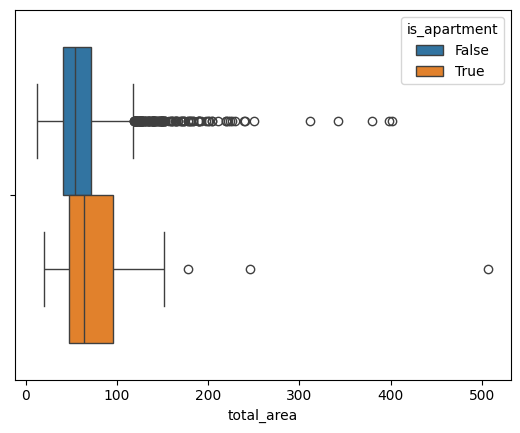

In [60]:
sns.boxplot(data=df, x="total_area", hue="is_apartment");

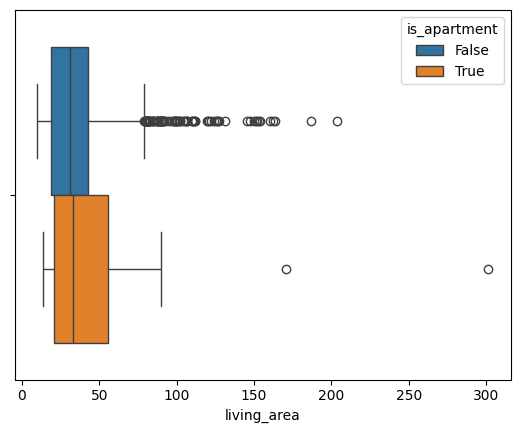

In [61]:
sns.boxplot(data=df, x="living_area", hue="is_apartment");

In [62]:
liv_area_threshold = np.percentile(df_is_apartment['living_area'].dropna(), 95)
total_area_threshold = np.percentile(df_is_apartment['total_area'].dropna(), 95)

Basic idea: Changing NaN to False in the *is_apartment* columns. Beside the living_area is more than *liv_area_threshold* and total_area is more than *total_area_threshold*

In [63]:
df['is_apartment'] = df['is_apartment'].fillna(df['living_area'].dropna() > liv_area_threshold)
df['is_apartment'] = df['is_apartment'].fillna(df['total_area'].dropna() > total_area_threshold)

C:\Users\Ilia\AppData\Local\Temp\ipykernel_7616\3167554976.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_apartment'] = df['is_apartment'].fillna(df['total_area'].dropna() > total_area_threshold)


In [64]:
print_result(df.drop(columns=['locality_name', 'first_day_exposition']).dropna())

MAE:	3_536_463.02
RMSE:	10_316_833.67
R²:	0.52


### 0.2.2 *parks_nearest*

Calculating correlation between *parks_nearest* and others columns and filter it by a condition: the correlation should be larger than 0.6

In [65]:
corr_dict = {col: df['parks_nearest'].corr(df[col])
             for col in df.columns if col != 'locality_name' and abs(df['parks_nearest'].corr(df[col])) > 0.6}
corr_dict

{'parks_nearest': np.float64(1.0)}

In [66]:
df['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Hard to undertand how the best (or just good) way to fill NaN values in the *parks_nearest*

In [67]:
df.drop(['parks_nearest'], axis=1, inplace=True)

In [68]:
print_result(df.drop(columns=['locality_name', 'first_day_exposition']).dropna())

MAE:	2_706_718.34
RMSE:	7_529_106.37
R²:	0.55


### 0.2.3 *ponds_nearest*

Calculating correlation between *ponds_nearest* and others columns and filter it by a condition: the correlation should be larger than 0.6

In [69]:
corr_dict = {col: df['ponds_nearest'].corr(df[col])
             for col in df.columns if col != 'locality_name' and abs(df['ponds_nearest'].corr(df[col])) > 0.6}
corr_dict

{'ponds_nearest': np.float64(1.0)}

Hard to undertand how the best (or just good) way to fill NaN values in the *ponds_nearest*

In [70]:
df.drop(['ponds_nearest'], axis=1, inplace=True)

In [71]:
print_result(df.drop(columns=['locality_name', 'first_day_exposition']).dropna())

MAE:	1_863_471.53
RMSE:	5_550_645.14
R²:	0.59


### 0.2.4 *floors_total* has been deleted a few cells above

### 0.2.5 *kitchen area*, *living area* (these columns will be deleted, it was discussed above)

In [72]:
df.drop(['kitchen_area', 'living_area'], axis=1, inplace=True)

In [73]:
print_result(df.drop(columns=['locality_name', 'first_day_exposition']).dropna())

MAE:	1_977_359.13
RMSE:	5_418_675.94
R²:	0.60


### 0.2.6 *balcony*

In [74]:
df['balcony'].value_counts()

balcony
1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: count, dtype: int64

In [75]:
df['balcony'].isna().sum()

np.int64(11519)

In [76]:
df_has_not_balcony = df[df['balcony'] <= 2]
df_has_balcony = df[df['balcony'] > 2]

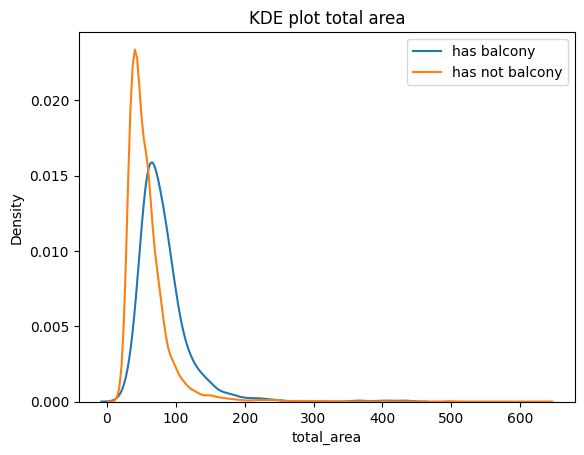

In [77]:
sns.kdeplot(data=df_has_balcony, x="total_area", label='has balcony')
sns.kdeplot(data=df_has_not_balcony, x="total_area", label='has not balcony')
plt.title("KDE plot total area")
plt.legend();

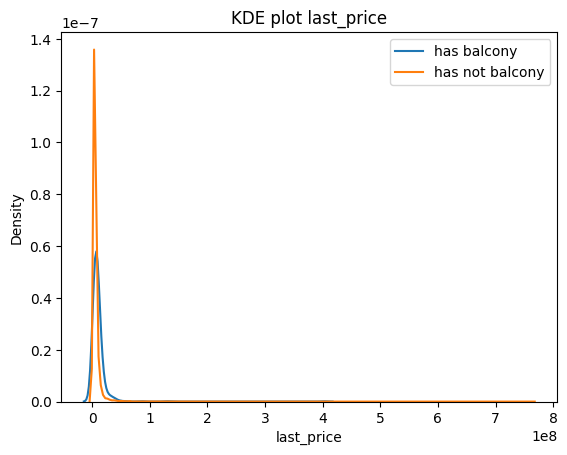

In [78]:
sns.kdeplot(data=df_has_balcony, x="last_price", label='has balcony')
sns.kdeplot(data=df_has_not_balcony, x="last_price", label='has not balcony')
plt.title("KDE plot last_price")
plt.legend();

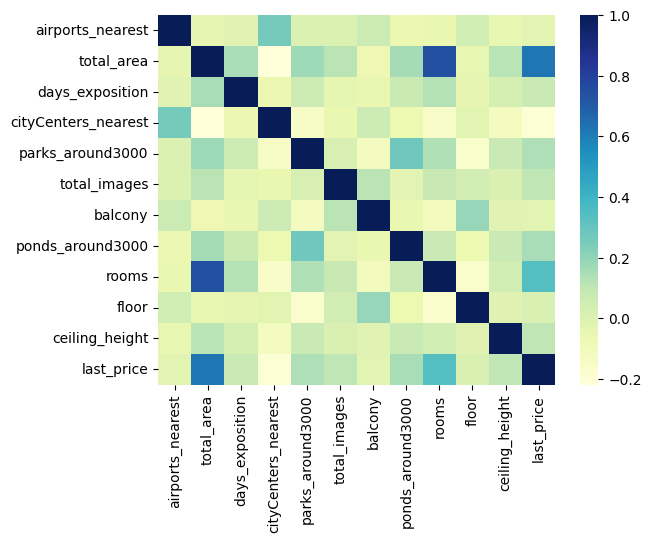

In [79]:
curr_num_col = list(set(numeric_columns) - set(['floors_total', 'parks_nearest', 'living_area', 'kitchen_area', 'ponds_nearest']))
sns.heatmap(df_has_not_balcony[curr_num_col].corr(),
            cmap="YlGnBu");

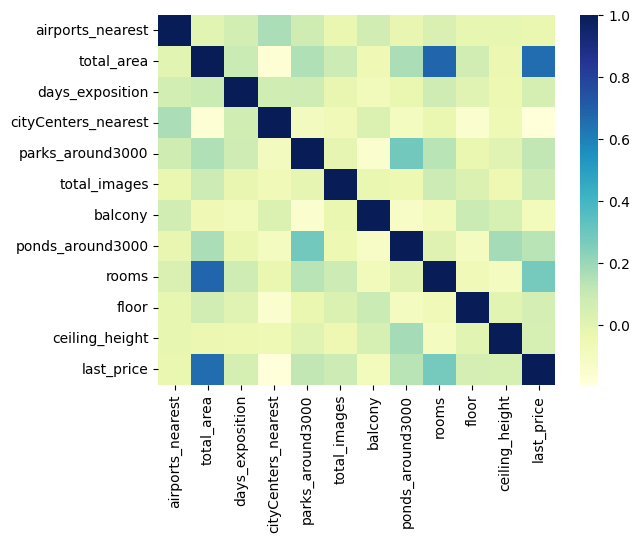

In [80]:
sns.heatmap(df_has_balcony[curr_num_col].corr(),
            cmap="YlGnBu");

Hard to undertand how the best (or just good) way to fill NaN values. The *balcony* will be dropped

In [81]:
df.drop(['balcony'], axis=1, inplace=True)
print_result(df.drop(columns=['locality_name', 'first_day_exposition']).dropna())

MAE:	2_298_174.32
RMSE:	7_189_744.21
R²:	0.62


### 0.2.7 *ceiling_height*

In [82]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [83]:
df.query("is_spb == True").ceiling_height.dropna().mean()

np.float64(2.8037094220110843)

In [84]:
df.query("is_spb != True").ceiling_height.dropna().mean()

np.float64(2.697531818181818)

In [85]:
np.percentile(df['ceiling_height'].dropna(), 90)

np.float64(3.06)

In [86]:
df['ceiling_height'].dropna().sort_values(ascending=True)

22590      1.00
5712       1.20
16934      1.75
5850       2.00
16446      2.00
          ...  
20478     27.00
21377     27.50
3148      32.00
22336     32.00
22869    100.00
Name: ceiling_height, Length: 14504, dtype: float64

Calculating correlation between *ceiling_height and others* columns and filter it by a condition: the correlation should be larger than 0.4

In [87]:
corr_dict = {col: df['ceiling_height'].corr(df[col])
             for col in df.columns if col != 'locality_name' and abs(df['ceiling_height'].corr(df[col])) > 0.4}
corr_dict

{'ceiling_height': np.float64(1.0)}

Hard to undertand how the best (or just good) way to fill NaN values. The *ceiling_height* will be dropped

In [88]:
df.drop(['ceiling_height'], axis=1, inplace=True)

In [89]:
print_result(df.drop(columns=['locality_name', 'first_day_exposition']).dropna())

MAE:	2_508_370.08
RMSE:	6_646_938.97
R²:	0.61


In [90]:
get_none_columns(df)

airports_nearest       5542.0
cityCenters_nearest    5519.0
ponds_around3000       5518.0
parks_around3000       5518.0
days_exposition        3181.0
locality_name            49.0
dtype: float64

### 0.2.8 *airports_nearest*, *cityCenters_nearest*

Gaps in airports_nearest, cityCenters_nearest will be filled using the locality_name column. The data will be obtained using the Yandex-geodata API.

Note: since there is a limit on the number of requests per day (no more than 1000), the results are pre-recorded in the dataset. In case of an exception, the dataset will be used automatically. The dataset is attached.

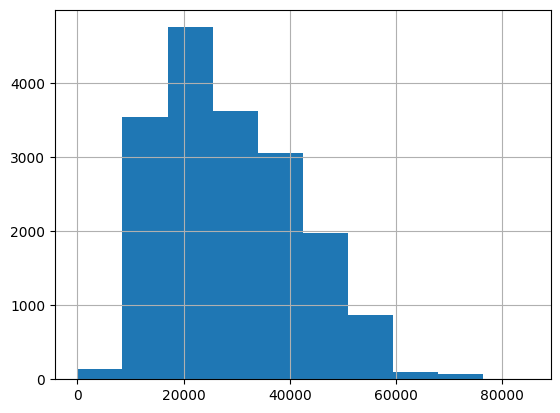

In [91]:
df['airports_nearest'].hist();

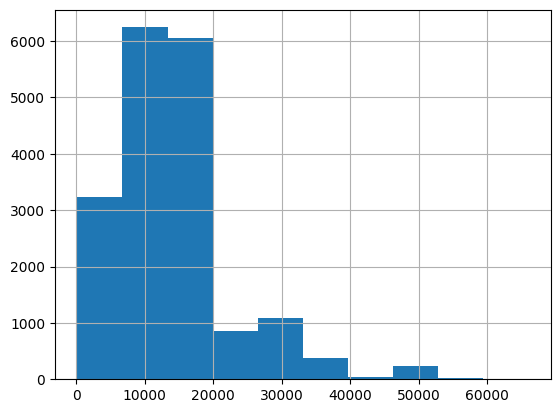

In [92]:
df['cityCenters_nearest'].hist();

In [93]:
cities_NaN_airport_center = df.query('airports_nearest != airports_nearest and cityCenters_nearest != cityCenters_nearest')['locality_name'].unique()
try:
    coordinates = get_city_coordinates(cities_NaN_airport_center)
    coordinates = get_df_coordinate(coordinates)
except KeyError:
    cities_with_NaN_airport_center = pd.read_csv('coordicates_1.csv') 

  0%|          | 0/345 [00:00<?, ?it/s]

{'response': {'GeoObjectCollection': {'metaDataProperty': {'GeocoderResponseMetaData': {'request': 'городской посёлок Янино-1', 'results': '10', 'found': '1'}}, 'featureMember': [{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'other', 'text': 'Россия, Ленинградская область, Всеволожский район, городской посёлок Янино-1', 'kind': 'locality', 'Address': {'country_code': 'RU', 'formatted': 'Россия, Ленинградская область, Всеволожский район, городской посёлок Янино-1', 'Components': [{'kind': 'country', 'name': 'Россия'}, {'kind': 'province', 'name': 'Северо-Западный федеральный округ'}, {'kind': 'province', 'name': 'Ленинградская область'}, {'kind': 'area', 'name': 'Всеволожский район'}, {'kind': 'locality', 'name': 'городской посёлок Янино-1'}]}, 'AddressDetails': {'Country': {'AddressLine': 'Россия, Ленинградская область, Всеволожский район, городской посёлок Янино-1', 'CountryNameCode': 'RU', 'CountryName': 'Россия', 'AdministrativeArea': {'AdministrativeAreaName

In [95]:
cities_with_NaN_airport_center = pd.read_csv('coordicates_1.csv')

In [96]:
spb_index = cities_with_NaN_airport_center[cities_with_NaN_airport_center.city == 'Санкт-Петербург'].index
cities_with_NaN_airport_center.drop(cities_with_NaN_airport_center.index[spb_index], inplace=True)
cities_with_NaN_airport_center = cities_with_NaN_airport_center.reset_index(drop=True)

In [97]:
cities_with_NaN_airport_center.coordinates = cities_with_NaN_airport_center.coordinates.apply(lambda x: (float(x.split(',')[0][1:]),
                                                            float(x.split(',')[1][1:-1])))

In [98]:
centre_coordinates = (59.946216, 30.311475)
airport_coordinates = (59.7998772, 30.2733421)

In [99]:
cities_with_NaN_airport_center['cityCenters_nearest'] = cities_with_NaN_airport_center['coordinates'].apply(
                                                        lambda x: distance.distance(x, centre_coordinates).m)
cities_with_NaN_airport_center['airports_nearest'] = cities_with_NaN_airport_center['coordinates'].apply(
                                                        lambda x: distance.distance(x, airport_coordinates).m)

cities_with_NaN_airport_center.head()

city             coordinates  cityCenters_nearest  \
0  городской посёлок Янино-1  (59.948429, 30.563255)         14073.804763   
1             посёлок Мурино  (60.051284, 30.438578)         13686.938457   
2                  Сертолово  (60.143531, 30.217179)         22602.725555   
3            деревня Кудрово  (59.908489, 30.513578)         12058.334158   
4                   Коммунар  (59.621609, 30.393483)         36456.127015   

   airports_nearest  
0      23186.131582  
1      29494.466883  
2      38415.349605  
3      18102.532766  
4      20980.070039

In [100]:
cityCenters_nearest_dict = dict(pd.Series(cities_with_NaN_airport_center['cityCenters_nearest'].values,
                                index=cities_with_NaN_airport_center['city'].values))
airports_nearest_dict = dict(pd.Series(cities_with_NaN_airport_center['airports_nearest'].values,
                                index=cities_with_NaN_airport_center['city'].values))

In [101]:
df.loc[df['cityCenters_nearest'].isnull(), 'cityCenters_nearest'] = df['locality_name'].map(cityCenters_nearest_dict)
df.loc[df['airports_nearest'].isnull(), 'airports_nearest'] = df['locality_name'].map(airports_nearest_dict)

In [102]:
get_none_columns(df)

ponds_around3000       5518.0
parks_around3000       5518.0
days_exposition        3181.0
airports_nearest         93.0
cityCenters_nearest      70.0
locality_name            49.0
dtype: float64

There is no necessary in *locality_name* column already

In [103]:
df.drop(['locality_name'], axis=1, inplace=True)

In [104]:
df['airports_nearest'].corr(df['last_price'])

np.float64(-0.039495604913333864)

Calculating correlation between *airports_nearest* and others columns and filter it by a condition: the correlation should be larger than 0.6

In [105]:
corr_dict = {col: df['airports_nearest'].corr(df[col])
             for col in df.columns if abs(df['airports_nearest'].corr(df[col])) > 0.4}
corr_dict

{'airports_nearest': np.float64(1.0),
 'cityCenters_nearest': np.float64(0.9975740924288333)}

In [106]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

MAE:	2_508_370.08
RMSE:	6_646_938.97
R²:	0.61


In [107]:
get_none_columns(df)

parks_around3000       5518.0
ponds_around3000       5518.0
days_exposition        3181.0
airports_nearest         93.0
cityCenters_nearest      70.0
dtype: float64

### 0.2.9 *parks_around3000*

In [108]:
df['parks_around3000'].value_counts()

parks_around3000
0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: count, dtype: int64

In [109]:
df['parks_around3000'].corr(df['last_price'])

np.float64(0.15105833966077947)

Calculating correlation between *parks_around3000* and others columns and filter it by a condition: the correlation should be larger than 0.4

In [110]:
corr_dict = {col: df['parks_around3000'].corr(df[col])
             for col in df.columns if abs(df['parks_around3000'].corr(df[col])) > 0.4}
corr_dict

{'parks_around3000': np.float64(1.0)}

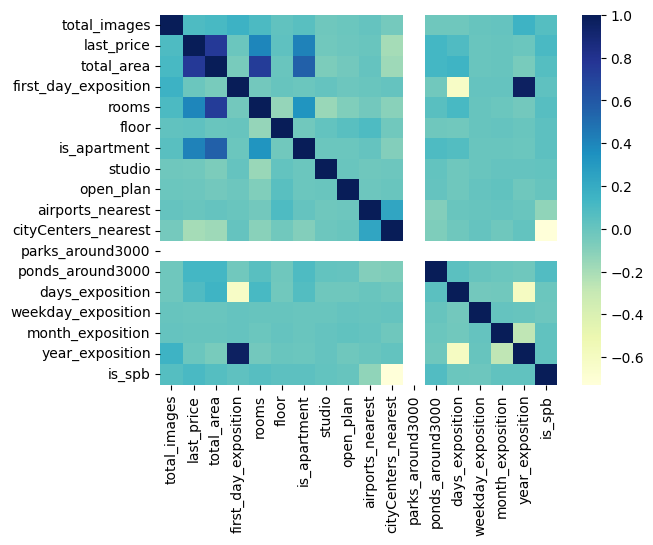

In [111]:
sns.heatmap(df[df['parks_around3000'] == 0].corr(),
            cmap="YlGnBu");

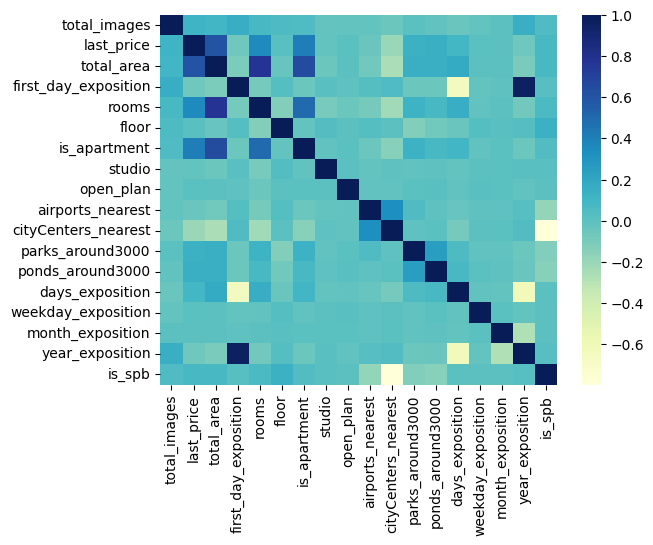

In [112]:
sns.heatmap(df[df['parks_around3000'] > 0].corr(),
            cmap="YlGnBu");

Hard to undertand how the best (or just good) way to fill NaN values. The *parks_around3000* will be dropped

In [113]:
df.drop(columns=['parks_around3000'], axis=1, inplace=True)

In [114]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

MAE:	2_514_861.71
RMSE:	6_654_873.83
R²:	0.61


In [115]:
get_none_columns(df)

ponds_around3000       5518.0
days_exposition        3181.0
airports_nearest         93.0
cityCenters_nearest      70.0
dtype: float64

### 0.2.10 *ponds_around3000*

In [116]:
df['ponds_around3000'].value_counts()

ponds_around3000
0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: count, dtype: int64

In [117]:
df['ponds_around3000'].corr(df['last_price'])

np.float64(0.1599956655508371)

Calculating correlation between *ponds_around3000* and others columns and filter it by a condition: the correlation should be larger than 0.4

In [118]:
corr_dict = {col: df['ponds_around3000'].corr(df[col])
             for col in df.columns if abs(df['ponds_around3000'].corr(df[col])) > 0.4}
corr_dict

{'ponds_around3000': np.float64(1.0)}

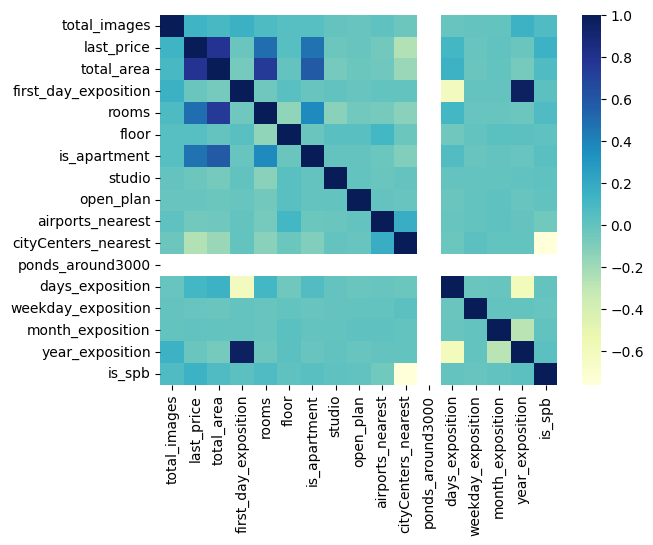

In [119]:
sns.heatmap(df[df['ponds_around3000'] == 0].corr(),
            cmap="YlGnBu");

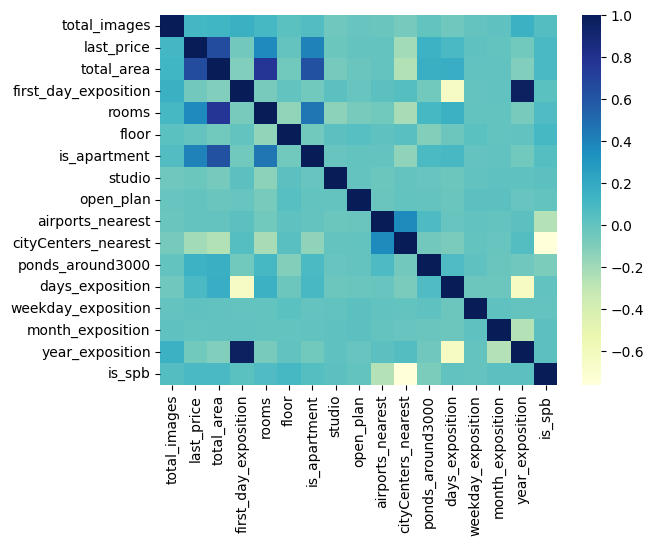

In [120]:
sns.heatmap(df[df['ponds_around3000'] > 0].corr(),
            cmap="YlGnBu");

In [121]:
df.drop(columns=['ponds_around3000'], axis=1, inplace=True)

Hard to undertand how the best (or just good) way to fill NaN values. The *ponds_around3000* will be dropped

In [122]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

MAE:	2_214_224.06
RMSE:	5_946_917.44
R²:	0.61


In [123]:
get_none_columns(df)

days_exposition        3181.0
airports_nearest         93.0
cityCenters_nearest      70.0
dtype: float64

### 0.2.11 *days_exposition*

<Axes: >

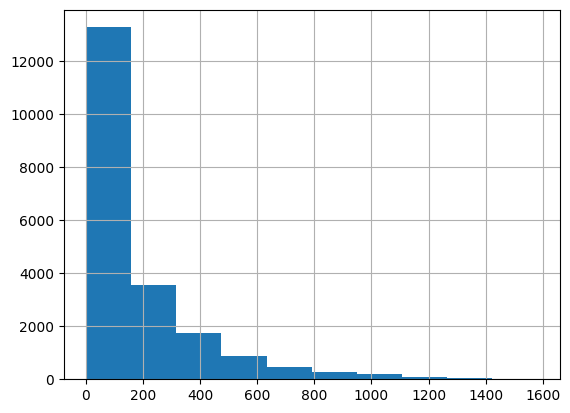

In [124]:
df['days_exposition'].hist()

In [125]:
df['days_exposition'].corr(df['last_price'])

np.float64(0.08114593098611303)

Calculating correlation between *days_exposition* and others columns and filter it by a condition: the correlation should be larger than 0.4

In [126]:
corr_dict = {col: df['days_exposition'].corr(df[col]) for col in df.columns if abs(df['days_exposition'].corr(df[col])) > 0.4}
corr_dict

{'first_day_exposition': np.float64(-0.6294943428768235),
 'days_exposition': np.float64(1.0),
 'year_exposition': np.float64(-0.6113075962510578)}

There is a strong correlation between *first_day_exposition* and *days_exposition*. The *first_day_exposition* will be deleted 

In [127]:
df.drop(columns=['first_day_exposition'], axis=1, inplace=True)

Again calculating correlation between *days_exposition* and others columns and filter it by a condition: the correlation should be larger than 0.4

In [128]:
corr_dict = {col: df['days_exposition'].corr(df[col]) for col in df.columns if abs(df['days_exposition'].corr(df[col])) > 0.4}
corr_dict

{'days_exposition': np.float64(1.0),
 'year_exposition': np.float64(-0.6113075962510578)}

In [129]:
df['days_exposition'] = np.log(df['days_exposition'])

In [130]:
df = df[df['days_exposition'].notna()]

In [131]:
df = df.reset_index(drop=True)

In [132]:
df = df.dropna()

In [133]:
# df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())

In [134]:
print_result(df.drop(columns=['airports_nearest', 'days_exposition']).dropna())

MAE:	2_213_217.51
RMSE:	5_946_310.35
R²:	0.61


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20464 entries, 0 to 20517
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_images         20464 non-null  int64  
 1   last_price           20464 non-null  float64
 2   total_area           20464 non-null  float64
 3   rooms                20464 non-null  int64  
 4   floor                20464 non-null  int64  
 5   is_apartment         20464 non-null  bool   
 6   studio               20464 non-null  bool   
 7   open_plan            20464 non-null  bool   
 8   airports_nearest     20464 non-null  float64
 9   cityCenters_nearest  20464 non-null  float64
 10  days_exposition      20464 non-null  float64
 11  weekday_exposition   20464 non-null  int32  
 12  month_exposition     20464 non-null  int32  
 13  year_exposition      20464 non-null  int32  
 14  is_spb               20464 non-null  bool   
dtypes: bool(4), float64(5), int32(3), int64(3

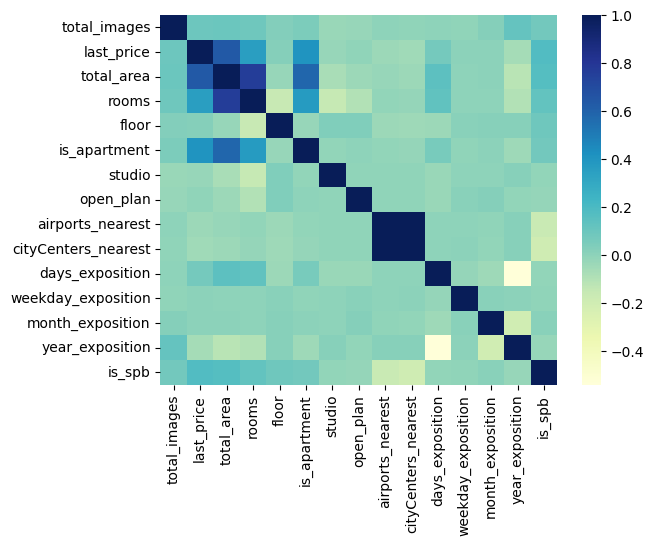

In [136]:
sns.heatmap(df.corr(),
            cmap="YlGnBu");

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20464 entries, 0 to 20517
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_images         20464 non-null  int64  
 1   last_price           20464 non-null  float64
 2   total_area           20464 non-null  float64
 3   rooms                20464 non-null  int64  
 4   floor                20464 non-null  int64  
 5   is_apartment         20464 non-null  bool   
 6   studio               20464 non-null  bool   
 7   open_plan            20464 non-null  bool   
 8   airports_nearest     20464 non-null  float64
 9   cityCenters_nearest  20464 non-null  float64
 10  days_exposition      20464 non-null  float64
 11  weekday_exposition   20464 non-null  int32  
 12  month_exposition     20464 non-null  int32  
 13  year_exposition      20464 non-null  int32  
 14  is_spb               20464 non-null  bool   
dtypes: bool(4), float64(5), int32(3), int64(3

In [138]:
numeric_columns = ['total_images', 'last_price', 'total_area', 'rooms', 'floor', 'days_exposition', 'airports_nearest', 'cityCenters_nearest',\
                  'days_exposition', 'weekday_exposition', 'month_exposition', 'year_exposition']
categorical_columns = ['is_apartment', 'studio', 'open_plan', 'is_spb']

In [139]:
df_numeric = df[numeric_columns]

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20464 entries, 0 to 20517
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_images         20464 non-null  int64  
 1   last_price           20464 non-null  float64
 2   total_area           20464 non-null  float64
 3   rooms                20464 non-null  int64  
 4   floor                20464 non-null  int64  
 5   is_apartment         20464 non-null  bool   
 6   studio               20464 non-null  bool   
 7   open_plan            20464 non-null  bool   
 8   airports_nearest     20464 non-null  float64
 9   cityCenters_nearest  20464 non-null  float64
 10  days_exposition      20464 non-null  float64
 11  weekday_exposition   20464 non-null  int32  
 12  month_exposition     20464 non-null  int32  
 13  year_exposition      20464 non-null  int32  
 14  is_spb               20464 non-null  bool   
dtypes: bool(4), float64(5), int32(3), int64(3

In [141]:
df['is_apartment'] = df['is_apartment'].astype(int)
df['studio'] = df['studio'].astype(int)
df['open_plan'] = df['open_plan'].astype(int)
df['is_spb'] = df['is_spb'].astype(int)

# VIF analysis

Variance Inflation Factor (VIF) is a metric used to assess the presence and severity of multicollinearity in multiple regression models. It measures how much the variance of a regression coefficient is inflated due to the linear dependence of an independent variable on other independent variables. A VIF value greater than 10 is typically considered indicative of high multicollinearity, suggesting that the variable may need to be removed or further investigated to ensure reliable model results.

Let's apply two methods: the first method is to apply VIF once and stop there; the second method is to apply and remove features while there is a VIF value greater than 10.

In [142]:
X_numeric = df_numeric.drop(['last_price'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                   for i in range(len(X_numeric.columns))]
vif_data.replace([np.inf, -np.inf], np.nan, inplace=True)
vif_data = vif_data.dropna()
ind_max = vif_data["VIF"].idxmax()
max_vif = vif_data.iloc[ind_max]["VIF"]
feature = vif_data.iloc[ind_max]["feature"]
if max_vif < 10:
    print(f'We have {vif_data.shape[0]} columns')
else:
    X_numeric = X_numeric.drop([feature], axis=1)


C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [143]:
vif_data

feature         VIF
0          total_images    3.937054
1            total_area   10.110797
2                 rooms   11.746950
3                 floor    2.627833
5      airports_nearest  213.998455
6   cityCenters_nearest  208.331941
8    weekday_exposition    3.105790
9      month_exposition    4.580776
10      year_exposition   27.179358

In [144]:
new_numeric_columns = vif_data.feature.to_list()
total_columns = new_numeric_columns + ['last_price']
total_columns = new_numeric_columns + categorical_columns + ['last_price']
new_df = df[total_columns]
print_result(new_df.dropna(), lasso=False)

MAE:	2_210_519.23
RMSE:	5_946_630.20
R²:	0.61


In [145]:
X_numeric = df_numeric.drop(['last_price'], axis=1)
while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_numeric.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                       for i in range(len(X_numeric.columns))]
    ind_max = vif_data["VIF"].idxmax()
    max_vif = vif_data.iloc[ind_max]["VIF"]
    feature = vif_data.iloc[ind_max]["feature"]
    if max_vif < 10:
        print(f'Finish! We have {vif_data.shape[0]} columns')
        break
    else:
        X_numeric = X_numeric.drop([feature], axis=1)

C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Finish! We have 6 columns


In [146]:
vif_data

feature       VIF
0         total_images  3.304572
1           total_area  3.289713
2                floor  2.220427
3  cityCenters_nearest  1.034447
4   weekday_exposition  2.632573
5     month_exposition  3.435825

In [147]:
new_numeric_columns = vif_data.feature.to_list()
total_columns = new_numeric_columns + ['last_price']
total_columns = new_numeric_columns + categorical_columns + ['last_price']
new_df = df[total_columns]
print_result(new_df.dropna(), lasso=False)

MAE:	2_435_582.19
RMSE:	6_267_946.90
R²:	0.57


The application of the Variance Inflation Factor (VIF) method did not yield any significant results in identifying multicollinearity among the independent variables.

### PCA

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) can be mathematically defined through several key steps and formulas:

1. **Standardization**: If the original dataset $X$ has $n$ observations and $p$ variables, the first step is to standardize the data by subtracting the mean and dividing by the standard deviation for each variable:

   $$
   Z = \frac{X - \mu}{\sigma}
   $$

   where $ \mu $ is the mean vector and $ \sigma $ is the standard deviation vector.

2. **Covariance Matrix**: Next, compute the covariance matrix $ C $ of the standardized data $ Z $:

   $$
   C = \frac{1}{n-1} Z^T Z
   $$

3. **Eigenvalues and Eigenvectors**: Calculate the eigenvalues $ \lambda $ and eigenvectors $ v $ of the covariance matrix $ C $ by solving the characteristic equation:

   $$
   \text{det}(C - \lambda I) = 0
   $$

   where $ I $ is the identity matrix.

4. **Sorting Eigenvectors**: Sort the eigenvalues in descending order and arrange the corresponding eigenvectors accordingly. The top $ k $ eigenvectors (where $ k $ is the number of desired principal components) will form the new subspace.

5. **Projection**: Finally, project the original standardized data $ Z $ onto the new subspace defined by the top $ k $ eigenvectors:

   $$
   Y = ZV_k
   $$

   where $ V_k $ is the matrix of the top $ k $ eigenvectors.

This results in a reduced-dimensional representation of the original data $ Y $, effectively capturing the most significant variance in the dataset.


In [148]:
features = df.drop('last_price', axis=1).columns
X_pca = df.drop('last_price', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
pca = PCA()
X_pca_transformed = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca_transformed, columns=features)
X_pca_df['last_price'] = df['last_price']

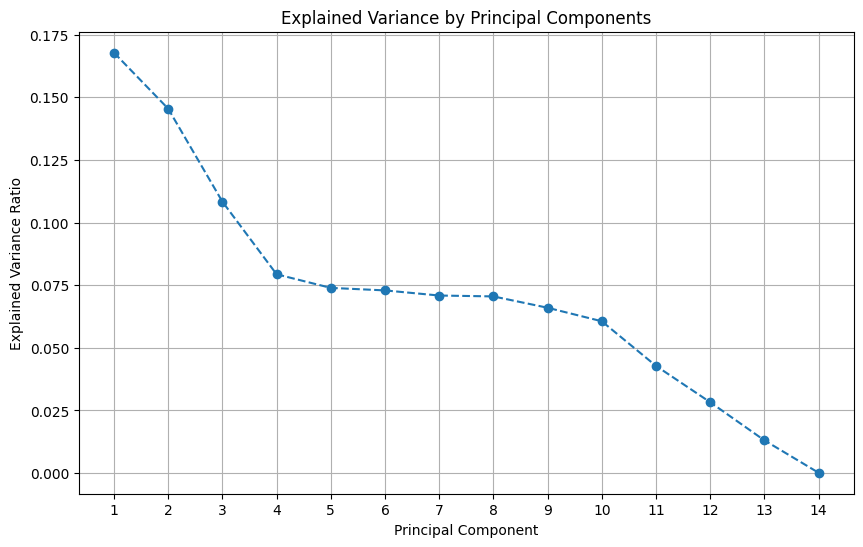

In [149]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

In [150]:
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

In [151]:
reduced_data = pca.fit_transform(df[features])

In [152]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    reduced_data,
    labels=labels,
    dimensions=range(len(features)),
)
fig.update_traces(diagonal_visible=False)
fig.write_html("scatter_plot_reduced_data.html")

In [153]:
for i in range(2, 13):
    X = reduced_data[:, :i]
    y = df['last_price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
    
    y_pred = linear_regressor.predict(X_test)
    
    mse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{i}: {mse=}, {r2=}')

2: mse=np.float64(14797754.637180373), r2=0.008551329452283318
3: mse=np.float64(12859327.336811993), r2=0.25128748282045865
4: mse=np.float64(12854168.838090083), r2=0.2518880520100567
5: mse=np.float64(12847738.57038251), r2=0.25263634727919515
6: mse=np.float64(12847758.41888134), r2=0.2526340380699963
7: mse=np.float64(12847496.957185468), r2=0.25266445669667437
8: mse=np.float64(12843908.769737393), r2=0.2530818462558434
9: mse=np.float64(12841827.17027196), r2=0.25332393119528807
10: mse=np.float64(12556369.38800718), r2=0.2861503388234442
11: mse=np.float64(12534499.288925892), r2=0.28863487336402704
12: mse=np.float64(12552897.210125456), r2=0.28654508195752293


# DOES NOT WORK

The application of Principal Component Analysis (PCA) did not yield the expected results, as a significant portion of the variance in the data remained unaccounted for, indicating the possible presence of nonlinear relationships or the need for alternative analytical methods.

# t-SNE

## t-SNE Overview

t-SNE is a popular dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data. It works by converting the pairwise similarities of data points into joint probabilities. Given a high-dimensional dataset $ X $, the pairwise similarities are represented by conditional probabilities $ p_{j|i} $:

$$
p_{j|i} = \frac{\exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)}{\sum_{k\neq i} \exp\left(-\frac{\|x_i - x_k\|^2}{2\sigma_i^2}\right)}
$$

where $ \sigma_i $ is the variance of the Gaussian distribution for the point $ x_i $.

In the low-dimensional space, the similarities are represented by a similar conditional probability $q_{j|i} $:

$$
q_{j|i} = \frac{\left(1 + \|y_i - y_j\|^2\right)^{-1}}{\sum_{k\neq i} \left(1 + \|y_i - y_k\|^2\right)^{-1}}
$$

where $ y_i $ and $ y_j $ are the low-dimensional representations of the high-dimensional points $ x_i $ and $ x_j $. The objective is to minimize the Kullback-Leibler divergence between the joint probabilities in the high-dimensional space $ P $ and the low-dimensional space $ Q $:

$$
\text{KL}(P \| Q) = \sum_{i} \sum_{j} p_{j|i} \log\left(\frac{p_{j|i}}{q_{j|i}}\right)
$$

through optimization techniques like gradient descent.


### n_components = 2

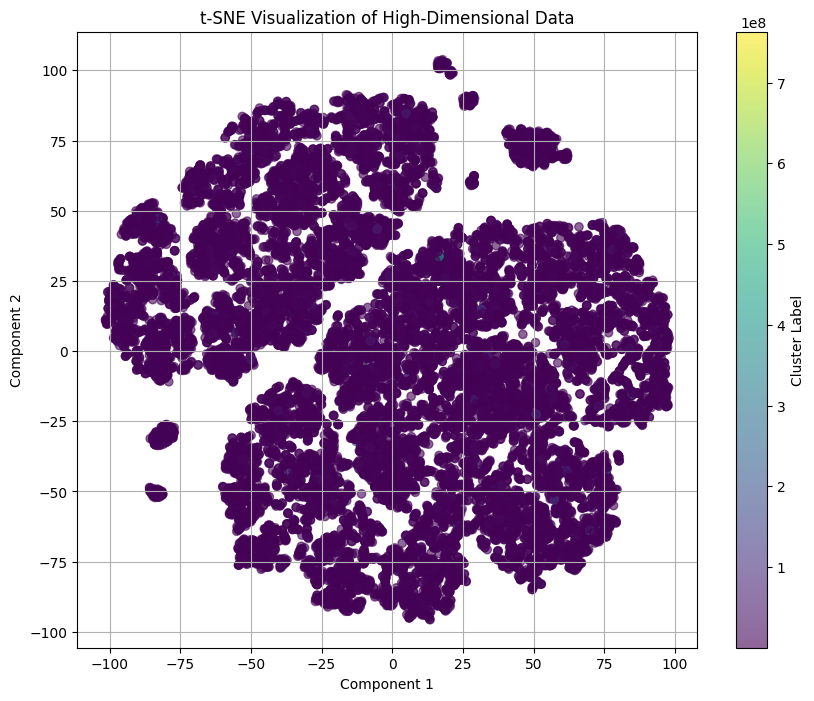

In [154]:
X = df.drop(['last_price'], axis=1)
tsne = TSNE(n_components=2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tsne = tsne.fit_transform(X_scaled)

# Step 4: Create a DataFrame for visualization
df_tsne = pd.DataFrame(data=X_tsne, columns=['Component_1', 'Component_2'])
df_tsne['last_price'] = df['last_price']

# Step 5: Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['Component_1'], df_tsne['Component_2'], c=df_tsne['last_price'], cmap='viridis', alpha=0.6)
plt.title("t-SNE Visualization of High-Dimensional Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

In [155]:
print_result(df_tsne.dropna())

MAE:	3_457_148.33
RMSE:	9_531_542.71
R²:	0.00


### n_components = 3

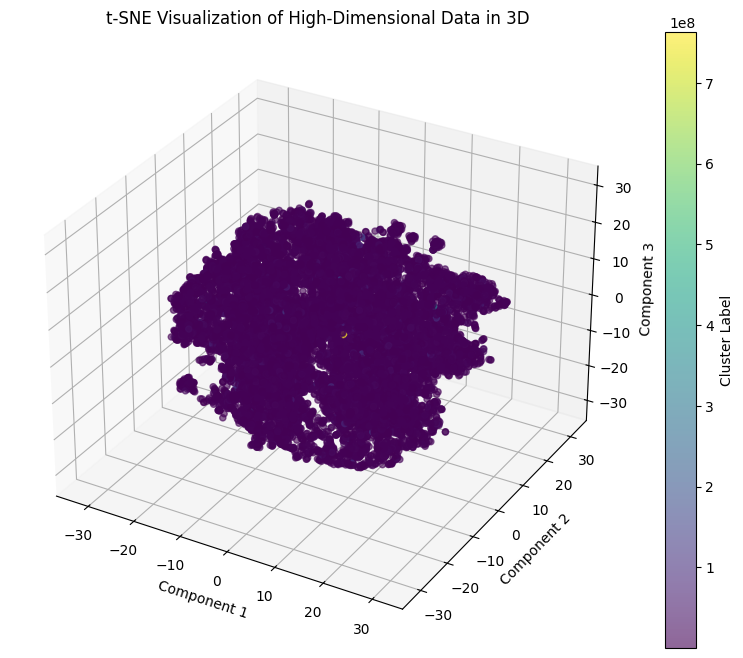

In [156]:
X = df.drop(['last_price'], axis=1)
tsne = TSNE(n_components=3, random_state=42)  # We want 3 components for 3D visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(data=X_tsne, columns=['Component_1', 'Component_2', 'Component_3'])
df_tsne['last_price'] = df['last_price']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_tsne['Component_1'], df_tsne['Component_2'], df_tsne['Component_3'], 
                     c=df_tsne['last_price'], cmap='viridis', alpha=0.6)

ax.set_title("t-SNE Visualization of High-Dimensional Data in 3D")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster Label')

plt.show()

In [157]:
print_result(df_tsne.dropna())

MAE:	3_457_437.43
RMSE:	9_532_120.22
R²:	0.00


The application of the t-distributed Stochastic Neighbor Embedding (t-SNE) method did not yield satisfactory results, as the produced visualization failed to adequately represent the underlying structure of the data, indicating potential issues with parameter settings or the necessity of alternative dimensionality reduction techniques.

# UMAP

## UMAP Overview

UMAP is a powerful dimensionality reduction technique that emphasizes the preservation of local and global structure in data. It operates on the premise that the data can be represented as a manifold and is based on concepts from topology and Riemannian geometry. First, UMAP constructs a weighted graph representation $ G $ of the high-dimensional dataset $ X $ by measuring local connectivity through nearest neighbors:

$$
W_{ij} = \exp\left(-\frac{d(x_i, x_j)^2}{\sigma_i^2}\right)
$$

where $ d(x_i, x_j) $ is the distance between points $ x_i $ and $ x_j $, and $ \sigma_i $ is a parameter that controls the influence of neighboring points.

Next, UMAP defines a low-dimensional representation $ Y $ that minimizes a cross-entropy loss function over the probabilistic representations in both high and low dimensions:

$$
\mathcal{L} = \sum_{i} \sum_{j} P_{ij} \log\left(\frac{P_{ij}}{Q_{ij}}\right)
$$

Here, $ P_{ij} $ represents the probabilities derived from the high-dimensional graph, and $ Q_{ij} $ represents the probabilities in the low-dimensional space defined typically using a Student's t-distribution. The optimization process aims to produce an embedding that retains the essential structure of the original data while reducing its dimensionality effectively.


# n_components = 2

C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



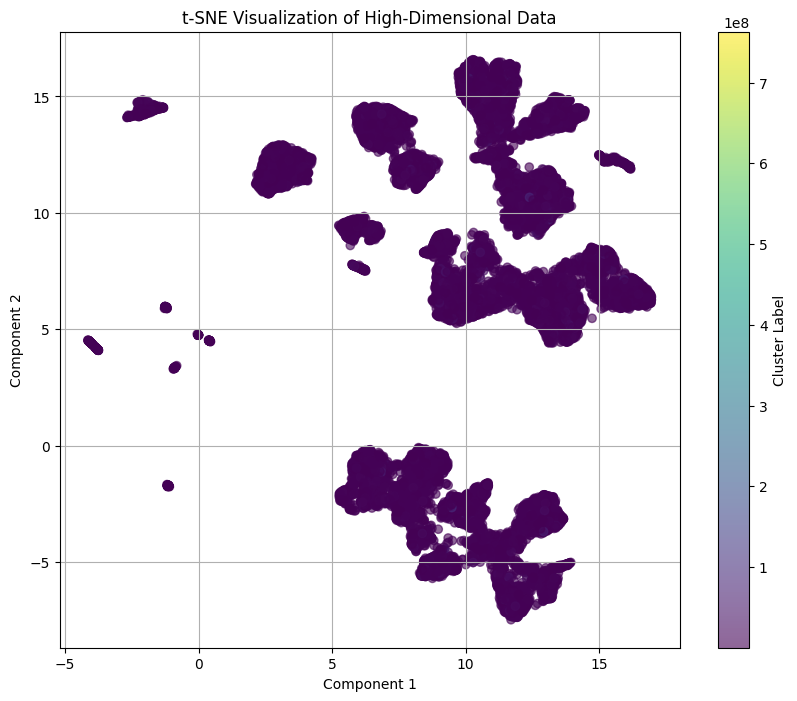

In [224]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(StandardScaler().fit_transform(X))

df_umap = pd.DataFrame(data=X_umap, columns=['Component_1', 'Component_2',])
df_umap['last_price'] = df['last_price']

# Step 5: Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_umap['Component_1'], df_umap['Component_2'],
                     c=df_umap['last_price'], cmap='viridis', alpha=0.6)

# Adding titles and labels
plt.title("t-SNE Visualization of High-Dimensional Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

In [226]:
print_result(df_umap.dropna())

MAE:	3_452_566.74
RMSE:	9_531_578.91
R²:	0.00


# n_components = 3

C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



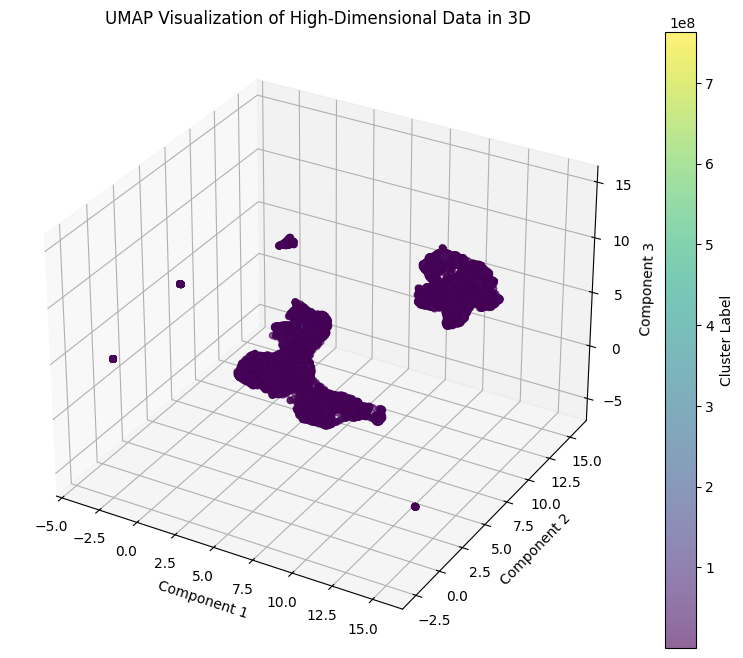

In [158]:
umap_model = umap.UMAP(n_components=3, random_state=42)  # We want 3 components for 3D visualization
X_umap = umap_model.fit_transform(StandardScaler().fit_transform(X))

# Step 4: Create a DataFrame for visualization
df_umap = pd.DataFrame(data=X_umap, columns=['Component_1', 'Component_2', 'Component_3'])
df_umap['last_price'] = df['last_price']

# Step 5: Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_umap['Component_1'], df_umap['Component_2'], df_umap['Component_3'], 
                     c=df_umap['last_price'], cmap='viridis', alpha=0.6)

# Adding titles and labels
ax.set_title("UMAP Visualization of High-Dimensional Data in 3D")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

# Adding a color bar for reference
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster Label')

plt.show()

In [159]:
print_result(df_umap.dropna())

MAE:	3_453_414.66
RMSE:	9_531_514.59
R²:	0.00


The application of the UMAP method did not yield the expected results, as the resulting low-dimensional visualization failed to adequately capture the data's structure, indicating the need for parameter adjustments or the consideration of alternative dimensionality reduction techniques.

# Factor Analysis

In [160]:
df_f = df.drop('last_price', axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
kmo_all, kmo_model = calculate_kmo(scaled_data)
print('KMO:', kmo_model)

KMO: 0.5334490890629454


In [161]:
chi_square, p_value = calculate_bartlett_sphericity(scaled_data)
kmo_all, kmo_model = calculate_kmo(scaled_data)

The result of Bartlett’s test for sphericity is zero (or a value very close to zero), it indicates that the correlation matrix is an identity matrix. This result means that the variables are not correlated with each other, suggesting that the data is not suitable for factor analysis. 

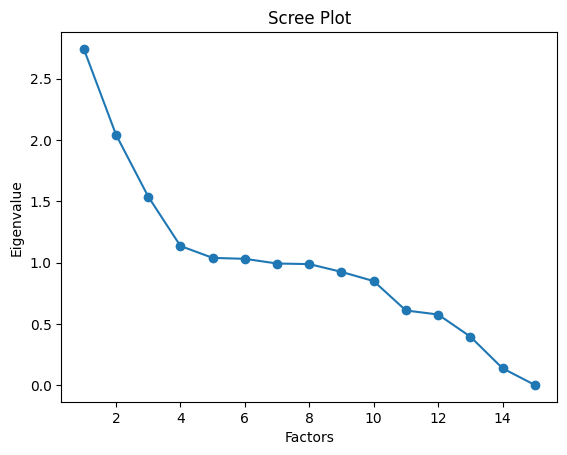

In [162]:
fa = FactorAnalyzer()
fa.fit(scaled_data)
eigenvalues, vectors = fa.get_eigenvalues()

plt.scatter(range(1, len(eigenvalues)+1), eigenvalues)
plt.plot(range(1, len(eigenvalues)+1), eigenvalues)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

In [163]:
eigenvalues = fa.get_eigenvalues()
explained_variance = eigenvalues[0]
explained_variance_ratio = explained_variance / sum(explained_variance)
print(f"Variance Explained (Proportion):\n{explained_variance_ratio}")

Variance Explained (Proportion):
[1.82822011e-01 1.36161349e-01 1.02515138e-01 7.56791731e-02
 6.92179164e-02 6.86866565e-02 6.61454634e-02 6.58287299e-02
 6.15991269e-02 5.65795123e-02 4.06163630e-02 3.84183885e-02
 2.64042600e-02 9.19013536e-03 1.35776102e-04]


In [164]:
for n_factors in range(2, 12):
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(scaled_data)
    
    factor_scores = fa.transform(scaled_data)
    
    X_factors = factor_scores
    y = df['last_price']
    
    X_train, X_test, y_train, y_test = train_test_split(X_factors, y, test_size=0.2, random_state=43)
    
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
    
    y_pred = linear_regressor.predict(X_test)
    
    mse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{n_factors}: {mse=}, {mae=}, {r2=}')

2: mse=np.float64(13124387.562852796), mae=np.float64(2416069.4105227273), r2=0.23368662762901438
3: mse=np.float64(13077323.76475617), mae=np.float64(2384824.606714088), r2=0.23917274305530134
4: mse=np.float64(11057331.19467301), mae=np.float64(2350875.156620388), r2=0.45606256753982277
5: mse=np.float64(11261888.478865096), mae=np.float64(2272330.0622245152), r2=0.43575105492892463
6: mse=np.float64(11223677.92872031), mae=np.float64(2272015.560008413), r2=0.43957344877658866
7: mse=np.float64(11583039.28954814), mae=np.float64(2159273.5703379572), r2=0.40311128244509575
8: mse=np.float64(11416219.088040266), mae=np.float64(2192868.418842713), r2=0.42018038880768815
9: mse=np.float64(11295238.250232011), mae=np.float64(2225858.457641152), r2=0.4324042919880279
10: mse=np.float64(2456116.0588989025), mae=np.float64(1250119.647587573), r2=0.9731622514029055
11: mse=np.float64(2490547.1528697037), mae=np.float64(1193179.8072997357), r2=0.9724045266486787


In [165]:
df.to_csv('fa_2.cvs', index=False)

# Написать вывод

# KMeans

K-Means is a popular clustering algorithm that partitions a dataset into $k$ distinct non-overlapping subsets (clusters) based on feature similarity. The algorithm works by initializing $k$ centroids, assigning each data point to the nearest centroid, and then recalculating the centroids as the mean of all points assigned to each cluster. This process iterates until the centroids stabilize, resulting in well-defined clusters. K-Means is widely used due to its simplicity, efficiency, and effectiveness in various applications, including market segmentation, image compression, and pattern recognition. However, it requires the user to specify the number of clusters, which may not always be obvious or optimal.

In [267]:
inertia = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    X = df.drop(['last_price'], axis=1)
    df_kmeans = df.copy()
    df_kmeans['KMeans_Cluster'] = kmeans.fit_predict(X)
    print(f'{i}:', end='')
    print(df_kmeans['KMeans_Cluster'].corr(df_kmeans['last_price']))
    inertia.append(kmeans.inertia_)

2:-0.02251608020792436
3:-0.021491219161505495
4:-0.0279206849095271
5:-0.09484289709745226
6:-0.09483843567464952
7:-0.1223242916139739
8:-0.12629148442936358
9:-0.05788132980098911


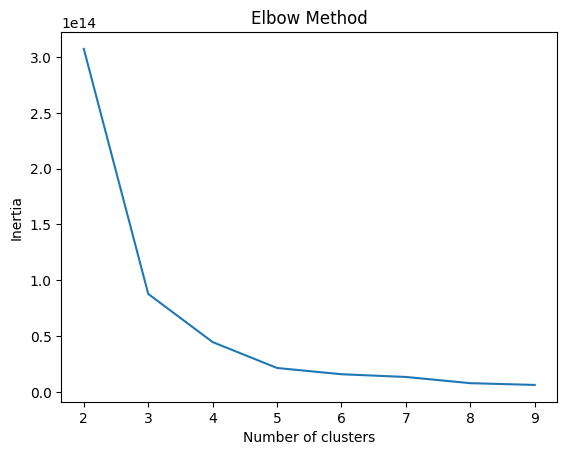

In [270]:
plt.plot(range(2, 10), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [271]:
kmeans = KMeans(n_clusters=3, random_state=42)
X = df.drop(['last_price'], axis=1)
df_kmeans = df.copy()
df_kmeans['KMeans_Cluster'] = kmeans.fit_predict(X)
print(df_kmeans['KMeans_Cluster'].corr(df_kmeans['last_price']))

-0.021491219161505495


In [272]:
df_kmeans['log_last_price'] = np.log(df_kmeans['last_price'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


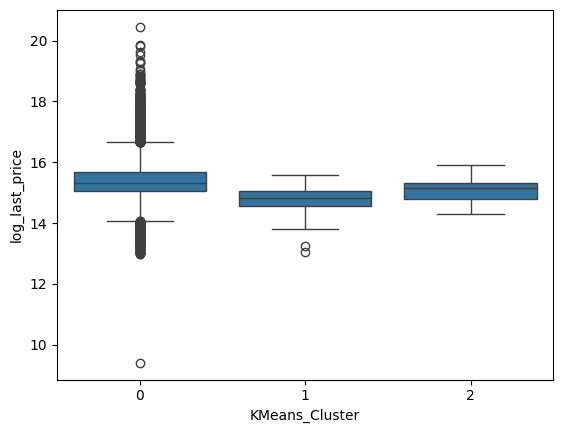

In [273]:
sns.boxplot(data=df_kmeans, y="log_last_price", x="KMeans_Cluster");

In [274]:
print_result(df_kmeans)

MAE:	2_369_920.91
RMSE:	5_938_642.91
R²:	0.61


In [275]:
print_result(df_kmeans.drop(['log_last_price'], axis=1))

MAE:	2_210_546.16
RMSE:	5_945_925.92
R²:	0.61


In [276]:
print_result(df_kmeans.drop(['last_price'], axis=1), target_col='log_last_price')

MAE:	0.22
RMSE:	0.34
R²:	0.71


K-Means did not degrade the results; however, there was no significant improvement observed either. The clustering performance remained stable, indicating that while K-Means maintained a consistent level of quality in the results, it did not enhance the insights gained from the data. This suggests that the algorithm effectively grouped the data, but there may be room for further optimization or exploration of alternative methods to achieve better-defined clusters.

After applying a logarithmic transformation to the target variable, the results improved significantly, which is quite interesting. This transformation helped to stabilize the variance and reduce the influence of outliers, leading to a more linear relationship between the features and the target. As a result, the model demonstrated enhanced predictive performance and better generalization to unseen data, highlighting the importance of data preprocessing in achieving optimal results.

# Polynomial Features

Recursive Feature Elimination (RFE) is a powerful feature selection technique that systematically removes less important features based on model performance. It works by recursively fitting a model and eliminating the least significant feature(s) at each iteration, thus ranking the features by their impact on the model's accuracy. RFE is particularly useful when dealing with high-dimensional datasets, as it helps in improving model interpretability and performance by retaining only the most relevant features.

Lasso (Least Absolute Shrinkage and Selection Operator) is a regularization technique used in linear regression that encourages simplicity and sparsity in the model by applying an $L_1$ penalty to the coefficients. This penalty forces some coefficients to become exactly zero, effectively performing feature selection by identifying and eliminating less important features from the model. Lasso not only helps in preventing overfitting, particularly in high-dimensional datasets, but also enhances model interpretability by retaining only the most significant predictors.

In [332]:
X = df.drop(['last_price'], axis=1)
y_price = df['last_price']
y = y_price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [333]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [334]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_poly, y_train)

y_pred = linear_regressor.predict(X_test_poly)

mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

11190129.608464567 0.35591385848939094


In [335]:
for n_features_to_select in range(2, 15):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    selected_features_rfe = X_train.columns[rfe.support_]
    print(f'{n_features_to_select}:')
    selected_features_rfe = list(selected_features_rfe)
    selected_features_rfe.extend(['last_price'])
    print_result(df[selected_features_rfe])
    print('----')

2:
MAE:	2_892_028.65
RMSE:	8_352_327.72
R²:	0.23
----
3:
MAE:	2_890_483.95
RMSE:	8_354_646.70
R²:	0.23
----
4:
MAE:	2_657_924.24
RMSE:	7_998_881.44
R²:	0.29
----
5:
MAE:	2_654_577.14
RMSE:	7_996_130.73
R²:	0.29
----
6:
MAE:	2_216_191.78
RMSE:	5_948_471.39
R²:	0.61
----
7:
MAE:	2_219_344.93
RMSE:	5_943_453.53
R²:	0.61
----
8:
MAE:	2_217_546.97
RMSE:	5_943_284.67
R²:	0.61
----
9:
MAE:	2_216_057.76
RMSE:	5_946_383.03
R²:	0.61
----
10:
MAE:	2_216_299.26
RMSE:	5_946_351.87
R²:	0.61
----
11:
MAE:	2_216_016.99
RMSE:	5_947_107.19
R²:	0.61
----
12:
MAE:	2_219_745.07
RMSE:	5_947_381.98
R²:	0.61
----
13:
MAE:	2_216_913.44
RMSE:	5_946_583.96
R²:	0.61
----
14:
MAE:	2_214_224.06
RMSE:	5_946_917.44
R²:	0.61
----


In [336]:
for n_features_to_select in range(2, 15):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    selected_features_rfe = X_train.columns[rfe.support_]
    print(f'{n_features_to_select}:')
    selected_features_rfe = list(selected_features_rfe)
    selected_features_rfe.extend(['last_price'])
    print_result(df[selected_features_rfe], lasso=True)
    print('----')

2:
Index(['is_apartment', 'is_spb'], dtype='object')
MAE:	2_892_028.53
RMSE:	8_352_327.69
R²:	0.23
----
3:
Index(['is_apartment', 'open_plan', 'is_spb'], dtype='object')
MAE:	2_890_483.81
RMSE:	8_354_646.64
R²:	0.23
----
4:
Index(['rooms', 'is_apartment', 'open_plan', 'is_spb'], dtype='object')
MAE:	2_657_923.92
RMSE:	7_998_881.46
R²:	0.29
----
5:
Index(['rooms', 'is_apartment', 'studio', 'open_plan', 'is_spb'], dtype='object')
MAE:	2_654_576.85
RMSE:	7_996_130.75
R²:	0.29
----
6:
Index(['total_area', 'rooms', 'is_apartment', 'studio', 'open_plan', 'is_spb'], dtype='object')
MAE:	2_216_190.89
RMSE:	5_948_471.25
R²:	0.61
----
7:
Index(['total_images', 'total_area', 'rooms', 'is_apartment', 'studio',
       'open_plan', 'is_spb'],
      dtype='object')
MAE:	2_219_344.02
RMSE:	5_943_453.39
R²:	0.61
----
8:
Index(['total_images', 'total_area', 'rooms', 'is_apartment', 'studio',
       'open_plan', 'year_exposition', 'is_spb'],
      dtype='object')
MAE:	2_217_546.09
RMSE:	5_943_284.52
R²:	

C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.490e+17, tolerance: 1.921e+14



The application of quadratic transformations and the Lasso method did not notably improve the model's results. While these techniques are often employed to capture non-linear relationships and perform regularization, their impact in this case was minimal. This suggests that the current feature set may already be sufficient for modeling, or it indicates the need for further exploration of alternative approaches or different feature engineering strategies to enhance performance.

# Bayes

In [158]:
hc = HillClimbSearch(df)
best_model = hc.estimate(scoring_method=BicScore(df))

# Output the learned structure
print("Learned Bayesian Network Structure:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Bayesian Network Structure:
[('rooms', 'is_apartment'), ('rooms', 'studio'), ('rooms', 'open_plan'), ('floor', 'is_spb'), ('studio', 'open_plan'), ('studio', 'balcony'), ('is_spb', 'rooms')]


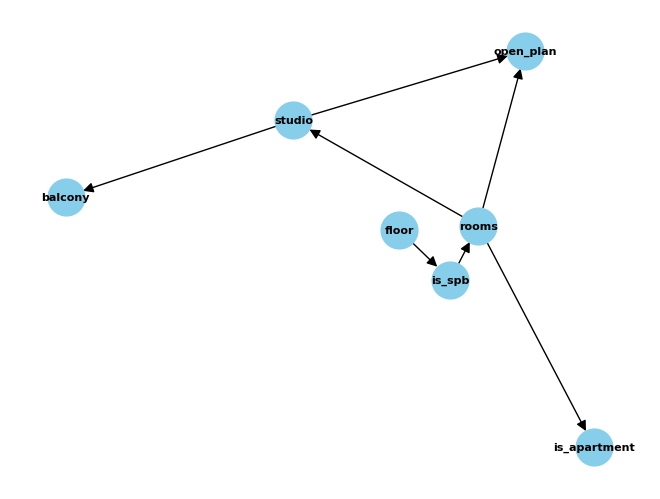

In [164]:
edges = best_model.edges()
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8, arrowsize=15)
plt.show()

In [186]:
df_kmeans.head()

total_images  last_price  total_area  rooms  floor  is_apartment  studio  \
0             7   3350000.0        40.4      1      1         False   False   
1            10   5196000.0        56.0      2      4         False   False   
2             0  64900000.0       159.0      3      9         False   False   
3             2  10000000.0       100.0      2     13         False   False   
4            10   2890000.0        30.4      1      5         False   False   

   open_plan  balcony  days_exposition  is_spb  KMeans_Cluster  log_last_price  
0      False        2         4.394449   False               0       15.024471  
1      False        0         6.324359    True               0       15.463400  
2      False        0         6.049733    True               1       17.988358  
3      False        0         4.795791    True               1       16.118096  
4      False        0         4.007333   False               0       14.876767

In [206]:
print_result(df_kmeans.drop(['open_plan', 'rooms', 'last_price'], axis=1), target_col='log_last_price')

RMSE:	0.35
R2:	0.70


# Fitting initial data

In [124]:
initial = pd.read_csv('./real_estate_data.csv', sep='\t')
initial = initial.drop(columns=[
    'first_day_exposition', 'ceiling_height', 'is_apartment', 'balcony', 'locality_name', 'parks_nearest', 'ponds_nearest'
])
initial = initial.dropna()
print_result(initial)

RMSE:	6_883_335.81
R2:	0.60
